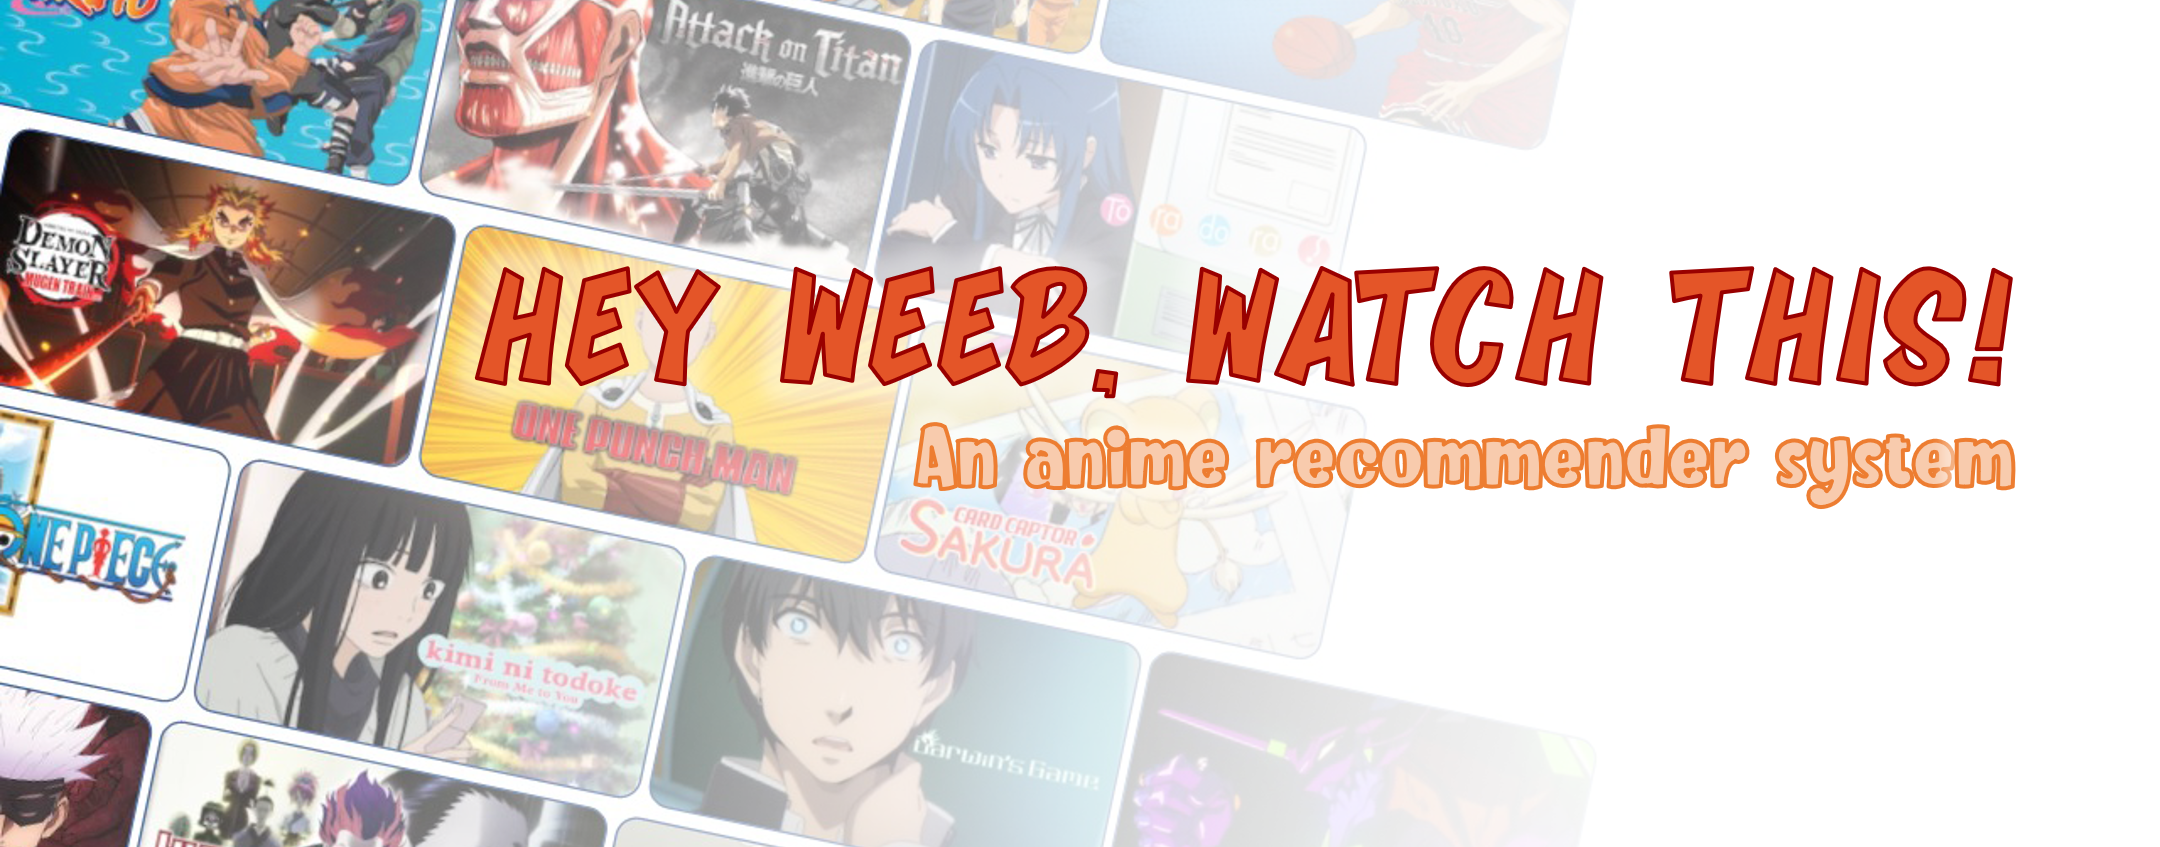

# <center>Hey Weeb, Watch This!: An Anime Recommender System</center>

In [1]:
# For Data Prep
import numpy as np
import pandas as pd
import ast
import sqlite3
from sqlalchemy import create_engine
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
from collections import Counter
import datetime
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from wordcloud import WordCloud, STOPWORDS
from PIL import Image
from tqdm import trange
from random import sample, seed
import time

# For data scaling
from sklearn.preprocessing import StandardScaler
from scipy.stats import norm

# For Recommender System
from surprise import (Reader, Dataset, accuracy)
from surprise import (BaselineOnly ,KNNWithMeans, SVD, SVDpp, NMF)
from surprise import (NormalPredictor, SlopeOne ,CoClustering)
from surprise.model_selection import cross_validate, train_test_split
from surprise.model_selection.search import GridSearchCV
from surprise.model_selection.split import KFold
import recmetrics
from sklearn.metrics import ndcg_score

# For FIM
import fim

# For Plotting
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import cycle
import matplotlib.cm as cm
from plotly.subplots import make_subplots
import plotly.graph_objects as gob
from matplotlib import pyplot
import seaborn as sns
import imageio.v3 as iio

# For Warnings
import warnings
warnings.filterwarnings("ignore")

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-i8mdvg5c because the default path (/home/jverdan/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [1]:
def countplot_with_percentages(serie):
    '''
    Accepts a pandas series of the ratings of all users then returns a
    bar plot of the distribution of the ratings
    '''
    ax = sns.countplot(serie)
    total_count = serie.count()

    for p in ax.patches:
        x = p.get_bbox().get_points()[:, 0]
        y = p.get_bbox().get_points()[1, 1]
        percentage = p.get_height() / total_count * 100
        ax.annotate(f'\n{percentage: .2f}%',
                    (x.mean(), y), ha='center', size=14)

def recsys_svd(df_rating, rating_scale, user_list, df_name):
    '''
    Accepts a user rating dataframe, tuple of rating scale, 
    predition method, and list of user to give recommendations
    then returns a dataframe of the top 5 liked and recommended
    items per user based on the prediction method passed.
    '''
    start_time = time.time()
    # Load your full dataset with rating scale
    df_rating = df_melt.pivot_table(values='rating', index='user_id',
                                    columns='anime_id')
    reader = Reader(rating_scale=rating_scale)
    dataset = Dataset.load_from_df(df_melt, reader)

    # Hyperparameter Tuning
    param_grid = {"n_epochs": [5, 10],
                  "n_factors": [90, 100],
                  "reg_all": [0.4, 0.6]}
    gs = GridSearchCV(SVD, param_grid, measures=["rmse"], cv=3)
    gs.fit(dataset)

    # Choose Best Estimator
    method = gs.best_estimator["rmse"]

    # Simplify fit the algorithm
    method.fit(dataset.build_full_trainset())
    cross_validate(method, dataset, measures=['RMSE'], cv=3,
                   verbose=True, n_jobs=-1)

    predictions = method.test(method.trainset.build_anti_testset())

    df_reco_user = pd.DataFrame()
    for user in user_list: # Get reco for N users
        top_n = []
        for uid, iid, true_r, est, _ in predictions:
            if uid == user:
                top_n.append((iid, est))
         # Get top N reco
        reco_list = sorted(top_n, key=lambda x: (-x[1], x[0]))[:10]
        top = [i[0] for i in reco_list]
        reco = df_name.loc[top].reset_index(drop=True)\
                                            .rename(columns={"name": user}).T
        x = df_name.loc[top].reset_index(drop=True)['name'].to_list()[:5]
        likes = df_rating.loc[user].dropna()\
                                    .sort_values(ascending=False).index
        y = df_name.loc[likes].reset_index(drop=True)['name'].to_list()[:5]
        assets = [user]
        Asset_feature = ['Likes', 'Recommends']
        index = ['Top1', 'Top2', 'Top3', 'Top4', 'Top5']

        midx = pd.MultiIndex.from_product([assets, Asset_feature])
        reco = pd.DataFrame([y,x], index=midx, columns=index).T
        df_reco_user = pd.concat([df_reco_user, reco], axis=1)
    run_time = (time.time() - start_time)
    return df_reco_user, predictions, run_time

def recsys_user(df_rating, rating_scale, user_list, df_name):
    '''
    Accepts a user rating dataframe, tuple of rating scale, 
    predition method, and list of user to give recommendations
    then returns a dataframe of the top 5 liked and recommended
    items per user based on the prediction method passed.
    '''
    start_time = time.time()
    # Load your full dataset with rating scale
    df_rating = df_melt.pivot_table(values='rating', index='user_id',
                                    columns='anime_id')
    reader = Reader(rating_scale=rating_scale)
    dataset = Dataset.load_from_df(df_melt, reader)

    # Hyperparameter Tuning
    param_grid = {
        'k': [15, 20],
        'sim_options': {
            'name': ['cosine'],
            'min_support': [5, 10],
            'user_based': [True],
        },
    }
    gs = GridSearchCV(KNNWithMeans, param_grid, measures=["rmse"], cv=3)
    gs.fit(dataset)

    # Choose Best Estimator
    method = gs.best_estimator["rmse"]

    # Simplify fit the algorithm
    method.fit(dataset.build_full_trainset())
    cross_validate(method, dataset, measures=['RMSE'], cv=3,
                   verbose=True, n_jobs=-1)

    predictions = method.test(method.trainset.build_anti_testset())

    df_reco_user = pd.DataFrame()
    for user in user_list: # Get reco for N users
        top_n = []
        for uid, iid, true_r, est, _ in predictions:
            if uid == user:
                top_n.append((iid, est))
                
         # Get top N reco
        reco_list = sorted(top_n, key=lambda x: (-x[1], x[0]))[:10]
        top = [i[0] for i in reco_list]
        reco = df_name.loc[top].reset_index(drop=True)\
                                .rename(columns={"name": user}).T
        x = df_name.loc[top].reset_index(drop=True)['name'].to_list()[:5]
        likes = df_rating.loc[user].dropna()\
                                    .sort_values(ascending=False).index
        y = df_name.loc[likes].reset_index(drop=True)['name'].to_list()[:5]
        assets = [user]
        Asset_feature = ['Likes', 'Recommends']
        index = ['Top1', 'Top2', 'Top3', 'Top4', 'Top5']

        midx = pd.MultiIndex.from_product([assets, Asset_feature])
        reco = pd.DataFrame([y,x], index=midx, columns=index).T
        df_reco_user = pd.concat([df_reco_user, reco], axis=1)
    run_time = (time.time() - start_time)
    return df_reco_user, predictions, run_time

def recsys_item(df_rating, rating_scale, user_list, df_name):
    '''
    Accepts a user rating dataframe, tuple of rating scale, 
    predition method, and list of user to give recommendations
    then returns a dataframe of the top 10 liked and recommended
    items per user based on the prediction method passed.
    '''
    # Load your full dataset with rating scale
    start_time = time.time()
    df_rating = df_melt.pivot_table(values='rating', index='user_id',
                                    columns='anime_id')
    reader = Reader(rating_scale=rating_scale)
    dataset = Dataset.load_from_df(df_melt, reader)

    # Hyperparameter Tuning
    param_grid = {
        'k': [15, 20],
        'sim_options': {
            'name': ['cosine'],
            'min_support': [5, 10],
            'user_based': [False],
        },
    }
    gs = GridSearchCV(KNNWithMeans, param_grid, measures=["rmse"], cv=3)
    gs.fit(dataset)

    # Choose Best Estimator
    method = gs.best_estimator["rmse"]

    # Simplify fit the algorithm
    method.fit(dataset.build_full_trainset())
    cross_validate(method, dataset, measures=['RMSE'], cv=3,
                   verbose=True, n_jobs=-1)

    predictions = method.test(method.trainset.build_anti_testset())

    df_reco_user = pd.DataFrame()
    for user in user_list: # Get reco for N users
        top_n = []
        for uid, iid, true_r, est, _ in predictions:
            if uid == user:
                top_n.append((iid, est))
        # Get top N reco
        reco_list = sorted(top_n, key=lambda x: (-x[1], x[0]))[:10] 
        top = [i[0] for i in reco_list]
        reco = df_name.loc[top].reset_index(drop=True)\
                                .rename(columns={"name": user}).T
        x = df_name.loc[top].reset_index(drop=True)['name'].to_list()[:5]
        likes = df_rating.loc[user].dropna()\
                                    .sort_values(ascending=False).index
        y = df_name.loc[likes].reset_index(drop=True)['name'].to_list()[:5]
        assets = [user]
        Asset_feature = ['Likes', 'Recommends']
        index = ['Top1', 'Top2', 'Top3', 'Top4', 'Top5']

        midx = pd.MultiIndex.from_product([assets, Asset_feature])
        reco = pd.DataFrame([y,x], index=midx, columns=index).T
        df_reco_user = pd.concat([df_reco_user, reco], axis=1)
    
    run_time = (time.time() - start_time)
    return df_reco_user, predictions, run_time

def recsys_svdpp(df_rating, rating_scale, user_list, df_name):
    '''
    Accepts a user rating dataframe, tuple of rating scale, 
    predition method, and list of user to give recommendations
    then returns a dataframe of the top 5 liked and recommended
    items per user based on the prediction method passed.
    '''
    start_time = time.time()
    # Load your full dataset with rating scale
    df_rating = df_melt.pivot_table(values='rating', index='user_id',
                                    columns='anime_id')
    reader = Reader(rating_scale=rating_scale)
    dataset = Dataset.load_from_df(df_melt, reader)

    # Hyperparameter Tuning
    param_grid = {"n_epochs": [5, 10],
                  "n_factors": [15, 20],
                  "reg_all": [0.4, 0.6]}
    gs = GridSearchCV(SVDpp, param_grid, measures=["rmse"], cv=3)
    gs.fit(dataset)

    # Choose Best Estimator
    method = gs.best_estimator["rmse"]

    # Simplify fit the algorithm
    method.fit(dataset.build_full_trainset())
    cross_validate(method, dataset, measures=['RMSE'], cv=3,
                   verbose=True, n_jobs=-1)

    predictions = method.test(method.trainset.build_anti_testset())

    df_reco_user = pd.DataFrame()
    for user in user_list: # Get reco for N users
        top_n = []
        for uid, iid, true_r, est, _ in predictions:
            if uid == user:
                top_n.append((iid, est))
         # Get top N reco
        reco_list = sorted(top_n, key=lambda x: (-x[1], x[0]))[:10]
        top = [i[0] for i in reco_list]
        reco = df_name.loc[top].reset_index(drop=True)\
                                            .rename(columns={"name": user}).T
        x = df_name.loc[top].reset_index(drop=True)['name'].to_list()[:5]
        likes = df_rating.loc[user].dropna()\
                                    .sort_values(ascending=False).index
        y = df_name.loc[likes].reset_index(drop=True)['name'].to_list()[:5]
        assets = [user]
        Asset_feature = ['Likes', 'Recommends']
        index = ['Top1', 'Top2', 'Top3', 'Top4', 'Top5']

        midx = pd.MultiIndex.from_product([assets, Asset_feature])
        reco = pd.DataFrame([y,x], index=midx, columns=index).T
        df_reco_user = pd.concat([df_reco_user, reco], axis=1)
    run_time = (time.time() - start_time)
    return df_reco_user, predictions, run_time

def recsys_nmf(df_rating, rating_scale, user_list, df_name):
    '''
    Accepts a user rating dataframe, tuple of rating scale, 
    predition method, and list of user to give recommendations
    then returns a dataframe of the top 5 liked and recommended
    items per user based on the prediction method passed.
    '''
    start_time = time.time()
    # Load your full dataset with rating scale
    df_rating = df_melt.pivot_table(values='rating', index='user_id',
                                    columns='anime_id')
    reader = Reader(rating_scale=rating_scale)
    dataset = Dataset.load_from_df(df_melt, reader)

    # Hyperparameter Tuning
    param_grid = {"n_epochs": [40, 50],
                  "n_factors": [15, 20]}
    
    gs = GridSearchCV(NMF, param_grid, measures=["rmse"], cv=3)
    gs.fit(dataset)

    # Choose Best Estimator
    method = gs.best_estimator["rmse"]

    # Simplify fit the algorithm
    method.fit(dataset.build_full_trainset())
    cross_validate(method, dataset, measures=['RMSE'], cv=3,
                   verbose=True, n_jobs=-1)

    predictions = method.test(method.trainset.build_anti_testset())

    df_reco_user = pd.DataFrame()
    for user in user_list: # Get reco for N users
        top_n = []
        for uid, iid, true_r, est, _ in predictions:
            if uid == user:
                top_n.append((iid, est))
         # Get top N reco
        reco_list = sorted(top_n, key=lambda x: (-x[1], x[0]))[:10]
        top = [i[0] for i in reco_list]
        reco = df_name.loc[top].reset_index(drop=True)\
                                            .rename(columns={"name": user}).T
        x = df_name.loc[top].reset_index(drop=True)['name'].to_list()[:5]
        likes = df_rating.loc[user].dropna()\
                                    .sort_values(ascending=False).index
        y = df_name.loc[likes].reset_index(drop=True)['name'].to_list()[:5]
        assets = [user]
        Asset_feature = ['Likes', 'Recommends']
        index = ['Top1', 'Top2', 'Top3', 'Top4', 'Top5']

        midx = pd.MultiIndex.from_product([assets, Asset_feature])
        reco = pd.DataFrame([y,x], index=midx, columns=index).T
        df_reco_user = pd.concat([df_reco_user, reco], axis=1)
    run_time = (time.time() - start_time)
    return df_reco_user, predictions, run_time

def recsys_slp(df_rating, rating_scale, user_list, df_name):
    '''
    Accepts a user rating dataframe, tuple of rating scale, 
    predition method, and list of user to give recommendations
    then returns a dataframe of the top 5 liked and recommended
    items per user based on the prediction method passed.
    '''
    start_time = time.time()
    # Load your full dataset with rating scale
    df_rating = df_melt.pivot_table(values='rating', index='user_id',
                                    columns='anime_id')
    reader = Reader(rating_scale=rating_scale)
    dataset = Dataset.load_from_df(df_melt, reader)

    # Hyperparameter Tuning
#     param_grid = {"n_cltr_u": [3],
#                   "n_cltr_i": [3],
#                   "n_epochs": [20]}
#     gs = GridSearchCV(SlopeOne, measures=["rmse"], cv=3)
#     gs.fit(dataset)

    # Choose Best Estimator
    method = SlopeOne()

    # Simplify fit the algorithm
    method.fit(dataset.build_full_trainset())
    cross_validate(method, dataset, measures=['RMSE'], cv=3,
                   verbose=True, n_jobs=-1)

    predictions = method.test(method.trainset.build_anti_testset())

    df_reco_user = pd.DataFrame()
    for user in user_list: # Get reco for N users
        top_n = []
        for uid, iid, true_r, est, _ in predictions:
            if uid == user:
                top_n.append((iid, est))
         # Get top N reco
        reco_list = sorted(top_n, key=lambda x: (-x[1], x[0]))[:10]
        top = [i[0] for i in reco_list]
        reco = df_name.loc[top].reset_index(drop=True)\
                                            .rename(columns={"name": user}).T
        x = df_name.loc[top].reset_index(drop=True)['name'].to_list()[:5]
        likes = df_rating.loc[user].dropna()\
                                    .sort_values(ascending=False).index
        y = df_name.loc[likes].reset_index(drop=True)['name'].to_list()[:5]
        assets = [user]
        Asset_feature = ['Likes', 'Recommends']
        index = ['Top1', 'Top2', 'Top3', 'Top4', 'Top5']

        midx = pd.MultiIndex.from_product([assets, Asset_feature])
        reco = pd.DataFrame([y,x], index=midx, columns=index).T
        df_reco_user = pd.concat([df_reco_user, reco], axis=1)
    run_time = (time.time() - start_time)
    return df_reco_user, predictions, run_time

def recsys_ccl(df_rating, rating_scale, user_list, df_name):
    '''
    Accepts a user rating dataframe, tuple of rating scale, 
    predition method, and list of user to give recommendations
    then returns a dataframe of the top 5 liked and recommended
    items per user based on the prediction method passed.
    '''
    start_time = time.time()
    # Load your full dataset with rating scale
    df_rating = df_melt.pivot_table(values='rating', index='user_id',
                                    columns='anime_id')
    reader = Reader(rating_scale=rating_scale)
    dataset = Dataset.load_from_df(df_melt, reader)

    # Hyperparameter Tuning
    param_grid = {"n_cltr_u": [3],
                  "n_cltr_i": [3],
                  "n_epochs": [20]}
    gs = GridSearchCV(CoClustering, param_grid, measures=["rmse"], cv=3)
    gs.fit(dataset)

    # Choose Best Estimator
    method = gs.best_estimator["rmse"]

    # Simplify fit the algorithm
    method.fit(dataset.build_full_trainset())
    cross_validate(method, dataset, measures=['RMSE'], cv=3,
                   verbose=True, n_jobs=-1)

    predictions = method.test(method.trainset.build_anti_testset())

    df_reco_user = pd.DataFrame()
    for user in user_list: # Get reco for N users
        top_n = []
        for uid, iid, true_r, est, _ in predictions:
            if uid == user:
                top_n.append((iid, est))
         # Get top N reco
        reco_list = sorted(top_n, key=lambda x: (-x[1], x[0]))[:10]
        top = [i[0] for i in reco_list]
        reco = df_name.loc[top].reset_index(drop=True)\
                                            .rename(columns={"name": user}).T
        x = df_name.loc[top].reset_index(drop=True)['name'].to_list()[:5]
        likes = df_rating.loc[user].dropna()\
                                    .sort_values(ascending=False).index
        y = df_name.loc[likes].reset_index(drop=True)['name'].to_list()[:5]
        assets = [user]
        Asset_feature = ['Likes', 'Recommends']
        index = ['Top1', 'Top2', 'Top3', 'Top4', 'Top5']

        midx = pd.MultiIndex.from_product([assets, Asset_feature])
        reco = pd.DataFrame([y,x], index=midx, columns=index).T
        df_reco_user = pd.concat([df_reco_user, reco], axis=1)
    run_time = (time.time() - start_time)
    return df_reco_user, predictions, run_time

def recsys_base(df_rating, rating_scale, user_list, df_name):
    '''
    Accepts a user rating dataframe, tuple of rating scale, 
    predition method, and list of user to give recommendations
    then returns a dataframe of the top 5 liked and recommended
    items per user based on the prediction method passed.
    '''
    start_time = time.time()
    # Load your full dataset with rating scale
    df_rating = df_melt.pivot_table(values='rating', index='user_id',
                                    columns='anime_id')
    reader = Reader(rating_scale=rating_scale)
    dataset = Dataset.load_from_df(df_melt, reader)

    # Hyperparameter Tuning
#     param_grid = {"n_cltr_u": [3],
#                   "n_cltr_i": [3],
#                   "n_epochs": [20]}
    gs = GridSearchCV(BaselineOnly, measures=["rmse"], cv=3)
    gs.fit(dataset)

    # Choose Best Estimator
    method = gs.best_estimator["rmse"]

    # Simplify fit the algorithm
    method.fit(dataset.build_full_trainset())
    cross_validate(method, dataset, measures=['RMSE'], cv=3,
                   verbose=True, n_jobs=-1)

    predictions = method.test(method.trainset.build_anti_testset())

    df_reco_user = pd.DataFrame()
    for user in user_list: # Get reco for N users
        top_n = []
        for uid, iid, true_r, est, _ in predictions:
            if uid == user:
                top_n.append((iid, est))
         # Get top N reco
        reco_list = sorted(top_n, key=lambda x: (-x[1], x[0]))[:10]
        top = [i[0] for i in reco_list]
        reco = df_name.loc[top].reset_index(drop=True)\
                                            .rename(columns={"name": user}).T
        x = df_name.loc[top].reset_index(drop=True)['name'].to_list()[:5]
        likes = df_rating.loc[user].dropna()\
                                    .sort_values(ascending=False).index
        y = df_name.loc[likes].reset_index(drop=True)['name'].to_list()[:5]
        assets = [user]
        Asset_feature = ['Likes', 'Recommends']
        index = ['Top1', 'Top2', 'Top3', 'Top4', 'Top5']

        midx = pd.MultiIndex.from_product([assets, Asset_feature])
        reco = pd.DataFrame([y,x], index=midx, columns=index).T
        df_reco_user = pd.concat([df_reco_user, reco], axis=1)
    run_time = (time.time() - start_time)
    return df_reco_user, predictions, run_time

def get_users_predictions(user_id, n, model):
    '''
    Accepts a user id, number of recommendations, and user rating dataframe
    then returns a list of top n recommendations for the user
    '''
    recommended_items = pd.DataFrame(model.loc[user_id])
    recommended_items.columns = ["predicted_rating"]
    recommended_items = recommended_items.sort_values('predicted_rating',
                                                      ascending=False)    
    recommended_items = recommended_items.head(n)
    return recommended_items.index.tolist()

# Executive Summary

On average, over a hundred anime seasons are produced each year and for anime enthusiasts and weebs, finding the series they would like is a difficult and time-consuming task. Out of the many anime seasons produced, only a few make it to the status of mainstream anime. The rest are overshadowed by the popularity of mainstream anime and often become known only to a few anime-watching communities. As more and more people pick up the hobby of watching anime, the more mainstream anime gains more fame and following. This results in these less-known yet brilliant anime series being lost and forgotten.

In this report, we want to create an anime recommender system that can generate personalized recommendations that users will like despite the large number and variety of anime series that exist. We created recommendation systems using (1) user-based collaborative filtering, (2) item-based collaborative filtering, (3) Slope One-based Collaborative Filtering, (4) Co-clustering-based Collaborative Filtering and three latent factor-based collaborative filtering methods namely (5a) SVD, (5b) NMF, and (5c) SVD++. Once the recommender systems are created, we evaluate each of them using several metrics, namely (1) error scores (RMSE, MSE), (2) coverage scores, (3) novelty scores, (4) personalization scores, (5) intra-list similarity score, and (6) runtime.

Our results suggest that each recommender system has its own set of advantages and disadvantages. SVD and SVD++ have the lowest prediction errors and highest intra-list similarity, but has the lowest coverage, personalization, and novelty. Moreover, SVD++ has a notably high runtime with more than five times the runtime of item based collaborative filtering which is the second highest in terms of runtime. Slope-one has the highest coverage, and high novelty and personalization. Co-clustering has the highest novelty and personalization, and the lowest runtime. NMF performs well in personalization, but is only mediocre in terms of coverage and novelty and has the highest prediction errors. User and item based collaborative filtering performed will in terms of novelty and personalization, with average prediction errors. Ultimately, the choice of a recommender system to be used depends on which evaluation metric the user deems to be important. To improve this report further, we can try out other algorithms like content-based collaborative filtering and batch recommender systems. We can also explore several other algorithms in the scikit-Surprise library to improve the performance of our recommender system.


# Problem Statement

As the library of Anime titles from different platforms grows, how do we create a recommender system that can suggest relatively unknown titles that are highly similar to the viewing history of a specific user and the recommendations being personalized to each viewer?

# Motivation

The history of Anime can be traced back to the birth of Japan’s film industry in the early 1900s and has emerged as one of Japan’s major cultural breakthroughs over the past century.[1] Known originally for in-depth and imaginative story-telling, Anime has evolved to where it is now by integrating animation technology advancements into the said art. This evolution led to an increase in the audience not only in Japan but even penetrated the global mainstream media. But even with the influence of different cultures, authors of anime title has stayed true to their beliefs and ensured that their visions and art style are the ones driving their products. And as the popularity of anime increased over time, there also has been an influx of authors who wanted the world to view their life's works resulting in a great number of titles being published. 

An increase in selection, however, is not always a positive thing. The high number of choices results in viewers spending hours, even days, scrolling through hundreds of anime never finding the content they like. To create a better streaming environment that boosts revenue and increases the time spent on the website, businesses need to provide tailor-fit suggestions based on a user’s needs. It can take a lot of time and effort to search for the right anime to watch. This is why a recommender system for anime titles is important as it will save users ample time by providing them with a personalized recommendation based on their needs. On the business side, a recommender system will help increase engagement, retention, and time spent on the platform, resulting in increased revenue and profitability. Businesses also want to keep the churn rate to a minimum to ensure longevity in the platform. With personalized recommendations, the platform will increase the likelihood of users staying and watching more anime, and at the same time attract more ad revenue and subscription revenue.

# Data Source

**Anime Recommendations Database**

This dataset is available in the jojie public dataset repository. It contains two files one being the database of the general overview of anime titles of different genres and various platforms. The other file is the information on user preference data from different users on the anime titles. Each user can add anime to their completed list and give it a rating and this dataset is a compilation of those ratings.

Filepath: /mnt/data/public/anime-recommendations-database/

**Database Summary:**
- +12,000 anime titles
- +73,000 users
- +7,800,000 anime user ratings
- 6 platforms

**Original Data Source**
This dataset was scraped and processed from myanimelist.net API 

The dataset can be downloaded from Kaggle: https://www.kaggle.com/datasets/CooperUnion/anime-recommendations-database

<h3><u>Anime Title Dataset</u></h3>

- This dataset contains a general overview of all the anime titles which includes title name, genre, platform or type of media, the total number of episodes, average ratings, and number of members subscribed to the title.


<h3><u>User Rating Dataset</u></h3>

- This dataset contains the user rating information such as user id, anime id linked to a specific anime title, and rating of the user to a single anime title.

<br />

# Data Exploration

<center><h3 style="color:#000000"><u>Raw Data Description</u></h3></center>

<span style="font-size: 16px">
    <center><b>Table 1. Anime Title Raw Data Description</b></center>
</span>

<center>Rows: 12,294<br>
Columns: 7<br>
No Null Values</center>
    
|<center>Variable Name</center>|<center>Data type</center>|<center>Variable Caterogy</center>|<center>Description</center>
|:---|:---|:---|:---|
|anime_id|string|string|myanimelist.net's unique id identifying an anime
|genre|string|string| comma-separated list of genres for this anime.
|type|string|string|type of platform the title is published
|episodes|integer|nominal|number of episodes in the title (1 if movie)
|rating|float|string|average user rating for the title (range: 1-10)
|members|integer|nominal|number of community members for the title

|       | episodes|rating |  members   |
|:------|--------:|------:|-----------:|
| mean  | 12.38   | 6.48  | 18368.56   |
| std   | 46.87   | 1.02  | 55110.78   |
| min   | 1.00    | 1.67  | 5.00       |
| 25%   | 1.00    | 5.89  | 229.00     |
| 50%   | 2.00    | 6.57  | 1579.50    |
| 75%   | 12.00   | 7.18  | 9755.50    |
| max   | 1818.00 | 10.00 | 1013917.00 |

<span style="font-size: 16px">
    <center><b>Table 2. User Rating Raw Data Description</b></center>
</span>

<center>Rows: 7,813,737<br>
Columns: 3<br>
Number of different users: 73,515 <br>
Number of different animes: 11,200 <br>
No Null Values</center>
    
|<center>Variable Name</center>|<center>Original Data type</center>|<center>Data type</center>|<center>Description</center>
|:---|:---|:---|:---|
|user_id|integer|nominal|non-identifiable randomly generated user id.
|anime_id|integer|nominal|the anime that this user has rated.
|rating|float|nominal|user rating of range 1 to 10 (-1 for titles with no ratings).


|       | user_id |anime_id |rating |
|:------|--------:|--------:|------:|
| mean  | 36727.96| 8909.07 | 6.14  |
| std   | 20997.95| 8883.95 | 3.73  |
| min   | 1.00    | 1.00    | -1.00 |
| 25%   | 18974.00| 1240.00 | 6.00  |
| 50%   | 36791.00| 6213.00 | 7.00  |
| 75%   | 54757.00| 14093.00| 9.00  |
| max   | 73516.00| 34519.00| 10.00 |


<span style="font-size: 16px">
    <center><b><u>Final Data Description</u></b></center>
</span>

<span style="font-size: 16px">
    <center><b>Table 3. Anime Profile Data Description</b></center>
</span>
    
<center>
Matrix Type: Sparse<br>
Rows: 4381 Anime Titles<br>
Columns: 37 Features<br>
No Null Values</center>

<span style="font-size: 16px">
    <center><b>Table 4. User Rating Data Description</b></center>
</span>
    
<center>
Matrix Type: Sparse<br>
Rows: 659 Users <br>
Columns: 4381 Anime Titles<br>
No Null Values</center>

## Exploring the Item Profile Data

### Loading Raw  Anime Data

In [3]:
# Read CSV
path = '/mnt/data/public/anime-recommendations-database/'
df_item = pd.read_csv(path + 'anime.csv')
display(df_item)

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266
...,...,...,...,...,...,...,...
12289,9316,Toushindai My Lover: Minami tai Mecha-Minami,Hentai,OVA,1,4.15,211
12290,5543,Under World,Hentai,OVA,1,4.28,183
12291,5621,Violence Gekiga David no Hoshi,Hentai,OVA,4,4.88,219
12292,6133,Violence Gekiga Shin David no Hoshi: Inma Dens...,Hentai,OVA,1,4.98,175


<span style="font-size: 12px">
    <center>Table 5. Unprocessed Anime Title Information Dataset</center>
</span>

### Loading Raw User Rating Data

In [4]:
path = '/mnt/data/public/anime-recommendations-database/'
df_ratings = pd.read_csv(path + 'rating.csv')

display(df_ratings.sample(5, random_state=143))

,user_id,anime_id,rating
2346025,22522,12231,-1
6609799,61036,1101,9
4319582,40829,10079,8
1122361,10776,846,9
5401289,51051,449,8


<span style="font-size: 12px">
    <center>Table 6. Unprocessed User Rating Dataset</center>
</span>

<h3 style="color:#000000">Data Pre-Processing</h3>

**For Table 1. Anime Title Raw Data Description:**
1. Loaded Table 1. Anime Title Raw Data Description as `df_item`.
2. Dropped rows with null values in the `genre` and `type` columns.
3. Dropped rows with values equal to `Unknown` in the `episodes` column.
4. Filled out the null values of the `rating` column with the median of the values.
5. Dropped rows with values equal to `Music` in the `type` column.
6. Dropped rows with values in the bottom half quantile in the `members` column.
7. Dropped rows with values less than 12 in the `episodes` column with `type` being `TV`.

**For Table 2. User Rating Raw Data:**
1. Loaded Table 2. User Rating Raw Data Description as `df_user`
2. Samples 1000 users in the `user_id` column.
3. Dropped users with less than 20 ratings made.

### Pre-processing the Anime Title Data

In [5]:
# Handling missing values
df_item = df_item.loc[df_item['episodes'] != 'Unknown']
df_item['episodes'] = df_item['episodes'].astype('int')
df_item = df_item.loc[df_item['genre'].isna() == False]
df_item = df_item.loc[df_item['type'].isna() == False]

df_item = df_item.fillna(df_item['rating'].median())

# Filtering
df_item = df_item.loc[df_item['type'] != 'Music']
df_item = df_item.loc[df_item['members'] >= df_item['members'].quantile(0.50)]
df_item = df_item.loc[((df_item['episodes'] >= 12) & \
                       (df_item['type'] == 'TV')) | (df_item['type'] != 'TV')]
df_item = df_item.drop(2).reset_index(drop=True)
# Taking anime_id
anime_list = df_item['anime_id']

# Creating name data
df_name = df_item[['anime_id', 'name']]
df_name = df_name.set_index('anime_id')

display(df_item)

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
3,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266
4,11061,Hunter x Hunter (2011),"Action, Adventure, Shounen, Super Power",TV,148,9.13,425855
...,...,...,...,...,...,...,...
5580,2862,Tokineiro,Hentai,OVA,2,5.22,2350
5581,6546,Pico: My Little Summer Story,Yaoi,OVA,1,5.21,5551
5582,5391,Pico to Chico,"Hentai, Yaoi",OVA,1,5.19,29463
5583,4866,Pico x CoCo x Chico,"Hentai, Yaoi",OVA,1,5.16,27411


<span style="font-size: 12px">
    <center>Table 7. Filtered Anime Title Information Dataset</center>
</span>

### Pre-processing User Rating Data

In [6]:
np.random.seed(143)
user_sample = df_ratings['user_id'].unique()
user_sample = np.random.choice(user_sample, size=1000, replace=True, p=None)
user_sample

df_user = df_ratings[df_ratings.rating >= 0].reset_index(drop=True)
df_user = df_user.loc[df_user['anime_id'].isin(anime_list)]
df_user = df_user.loc[df_user['user_id'].isin(user_sample)]
df_user = df_user[df_user.groupby('user_id')['user_id']\
                                                  .transform('size') >= 20]
df_user = df_user.reset_index(drop=True)

# Anime ID from User
user_anime_list = df_user['anime_id'].unique().tolist()
df_user

,user_id,anime_id,rating
0,171,19,10
1,171,20,10
2,171,93,10
3,171,94,10
4,171,121,10
...,...,...,...
76966,73361,5079,9
76967,73361,5163,10
76968,73361,6030,9
76969,73361,6922,10


<span style="font-size: 12px">
    <center>Table 8. Filtered User Rating Dataset</center>
</span>

### Creating User Rating Matrix and Item Profile Matrix

In [7]:
# Extracting columns from ingredient's list then onehot encode ingredients
df_item = df_item.loc[df_item['anime_id'].isin(user_anime_list)]

tfidf = TfidfVectorizer(
    analyzer=lambda d: d.split(', '),
    stop_words='english',
    max_df=0.9,
    min_df=0.03
)

genres = tfidf.fit_transform(df_item['genre'])
df_genre = pd.DataFrame(genres.todense(),
                        columns=tfidf.get_feature_names_out(),
                         index=df_item.index)
df_anime = df_item.join(df_genre).drop('genre', axis=1)
df_anime = df_anime.drop(['name'], axis=1)
df_anime = df_anime.set_index('anime_id')
df_anime = pd.get_dummies(df_anime, columns=['type'], drop_first=False)

# Scaling Item Profile
scaler = StandardScaler()
X_item_profile = scaler.fit_transform(df_anime)
df_anime = pd.DataFrame(data=X_item_profile, index=df_anime.index,
                        columns=df_anime.columns)
df_anime

,episodes,rating,members,Action,Adventure,Comedy,Demons,Drama,Ecchi,Fantasy,...,Slice of Life,Space,Sports,Super Power,Supernatural,type_Movie,type_ONA,type_OVA,type_Special,type_TV
anime_id,,,,,,,,,,,,,,,,,,,,,
32281,-0.340605,3.128669,1.881991,-0.678033,-0.518037,-0.809056,-0.180384,1.786279,-0.322984,-0.505105,...,-0.358378,-0.205459,-0.223713,-0.255614,2.657690,2.474586,-0.170671,-0.573045,-0.418522,-0.877554
5114,1.384915,2.971470,9.094745,0.822031,1.150253,-0.809056,-0.180384,1.139501,-0.322984,1.156891,...,-0.358378,-0.205459,-0.223713,-0.255614,-0.402570,-0.404108,-0.170671,-0.573045,-0.418522,1.139531
9253,0.289347,2.842853,7.634121,-0.678033,-0.518037,-0.809056,-0.180384,-0.519936,-0.322984,-0.505105,...,-0.358378,-0.205459,-0.223713,-0.255614,-0.402570,-0.404108,-0.170671,-0.573045,-0.418522,1.139531
9969,1.028855,2.828562,1.281604,0.847373,-0.518037,0.301377,-0.180384,-0.519936,-0.322984,-0.505105,...,-0.358378,-0.205459,-0.223713,-0.255614,-0.402570,-0.404108,-0.170671,-0.573045,-0.418522,1.139531
11061,3.685609,2.785689,4.621277,1.324434,1.708998,-0.809056,-0.180384,-0.519936,-0.322984,-0.505105,...,-0.358378,-0.205459,-0.223713,4.461716,-0.402570,-0.404108,-0.170671,-0.573045,-0.418522,1.139531
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2592,-0.340605,-2.701986,-0.517124,1.151421,-0.518037,-0.809056,-0.180384,-0.519936,-0.322984,-0.505105,...,-0.358378,-0.205459,-0.223713,-0.255614,2.282966,-0.404108,-0.170671,1.745063,-0.418522,-0.877554
730,-0.313216,-2.787731,-0.502821,-0.678033,-0.518037,-0.809056,-0.180384,2.995808,-0.322984,-0.505105,...,-0.358378,-0.205459,-0.223713,-0.255614,-0.402570,-0.404108,-0.170671,1.745063,-0.418522,-0.877554
5391,-0.340605,-2.844895,-0.199818,-0.678033,-0.518037,-0.809056,-0.180384,-0.519936,-0.322984,-0.505105,...,-0.358378,-0.205459,-0.223713,-0.255614,-0.402570,-0.404108,-0.170671,1.745063,-0.418522,-0.877554


<span style="font-size: 12px">
    <center>Table 9. Final Item Profile Matrix</center>
</span>

In [8]:
df_rating = pd.pivot_table(df_user, values='rating', index='user_id',
                            columns='anime_id')
df_rating

anime_id,1,5,6,7,8,15,16,17,18,19,...,33338,33341,33350,33421,33524,33558,33569,33741,33964,34103
user_id,,,,,,,,,,,,,,,,,,,,,
171,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
260,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
291,NaN,NaN,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
332,9.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
406,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72915,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
73175,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
73244,NaN,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<span style="font-size: 12px">
    <center>Table 10. Final User Profile Matrix</center>
</span>

<h3 style="color:#000000">Insights from the Data</h3>

<span style="font-size: 18px">
    <b>~43.5 percent</b> of the Anime Titles are TV series productions.
</span>

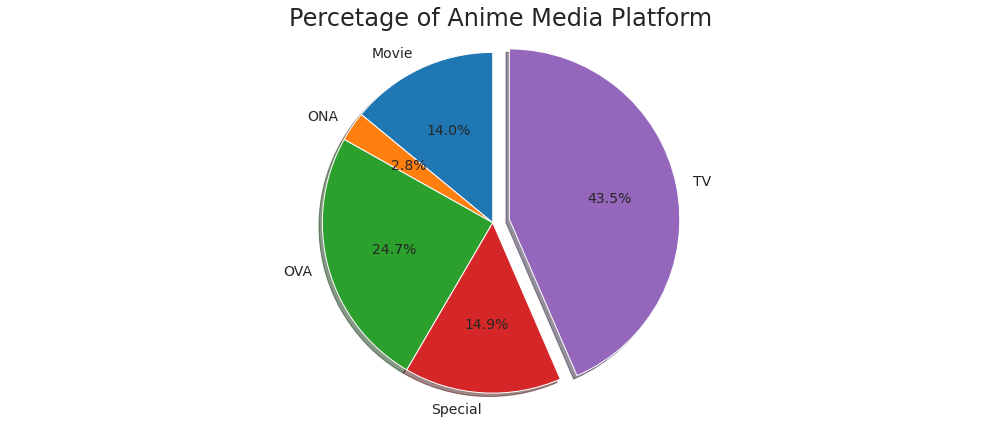

In [9]:
sns.set_style({'axes.grid' : False})
palette = sns.color_palette('flare')
sns.set_style('darkgrid')

df_pie = df_item.groupby('type')['rating'].count()

explode = (0, 0, 0, 0, 0.1)

plt.figure(figsize =(14, 6))
plt.pie(df_pie.values,
        explode=explode, labels=df_pie.index, autopct='%1.1f%%',
        shadow=True, startangle=90, textprops={'fontsize': 14})
# Equal aspect ratio ensures that pie is drawn as a circle
plt.axis('equal')
plt.title('Percetage of Anime Media Platform', fontsize=24)
plt.tight_layout()
plt.show()

<span style="font-size: 12px">
    <center>Figure 1. Distrubution of the Media Platform for Anime Titles</center>
</span>

<span style="font-size: 18px">
    <b>~93.37 percent</b> of ratings are <b>above 5</b>. <br>
    Only <b>~14.43 percent</b> of the ratings are a perfect <b>10</b>.
</span>

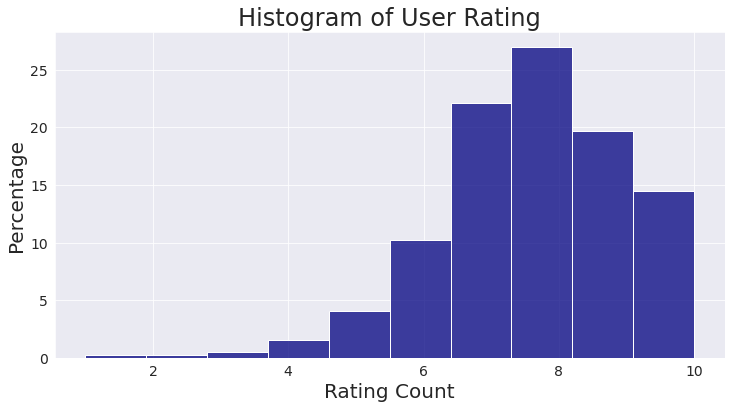

In [10]:
a4_dims = (12, 6);
fig, ax = pyplot.subplots(figsize=a4_dims);
ax = sns.histplot(data=df_user.sort_values('rating'),
             x='rating', common_bins=True, bins=10, stat='percent',
             color='navy')
plt.xlabel("Rating Count", fontsize = 20)
plt.ylabel("Percentage", fontsize = 20)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.title("Histogram of User Rating", fontsize = 24);

<span style="font-size: 12px">
    <center>Figure 2. Distrubution of the User Rating for Anime Titles</center>
</span>

<span style="font-size: 18px">
    <b>805</b> items have only <b>one</b> rating which is <b>~18.37%</b> of the total dataset.
</span>

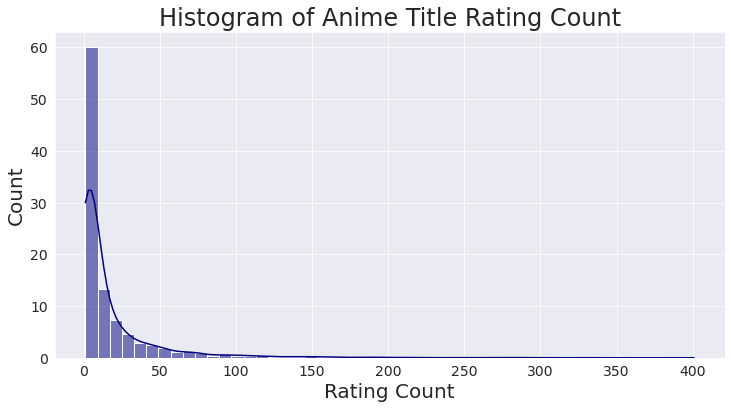

In [11]:
count = (df_user.loc[df_user['rating'] > 0]).groupby('anime_id')\
                        ['rating'].count().sort_values(ascending=False)
a4_dims = (12, 6)
fig, ax = pyplot.subplots(figsize=a4_dims)
ax = sns.histplot(data=count.reset_index(),
             x='rating', common_bins=True, bins=50,
             kde=True, stat='percent',
             color='navy',)
plt.xlabel("Rating Count", fontsize = 20)
plt.ylabel("Count", fontsize = 20)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.title("Histogram of Anime Title Rating Count", fontsize = 24);

<span style="font-size: 12px">
    <center>Figure 3. Distrubution of the Number of User Ratings per Anime Titles</center>
</span>

<span style="font-size: 18px">
    <b>Science Fiction</b>, <b>Romance, School</b>, and <b>Slice of Life</b> are the recurring genre.
</span>

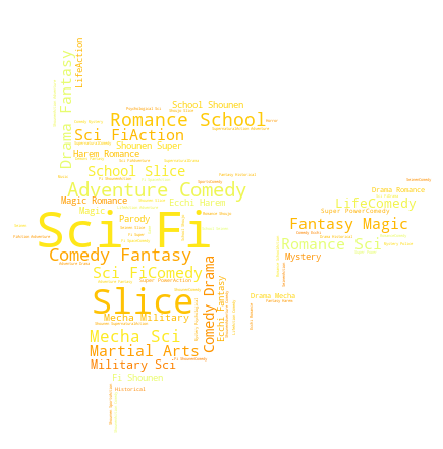

In [12]:
text_list = df_item['genre'].to_list()
text = ''.join(text_list)

mask = np.array(Image.open("pikachu.png"))

wc = WordCloud(width=3000, height=2000, random_state=1,
               max_words=100, max_font_size=500,
               background_color='white', colormap='Wistia',
               stopwords = STOPWORDS, mask=mask)
wc.generate(text)

plt.figure(figsize=(16, 8))
plt.imshow(wc, interpolation="None")
plt.axis('off')
plt.show()

<span style="font-size: 12px">
    <center>Figure 4. Wordcloud of the Genre of Anime Titles</center>
</span>

<span style="font-size: 18px">
    <b>Action</b> and <b>Shounen</b> are the genre with the highest rated titles
</span>

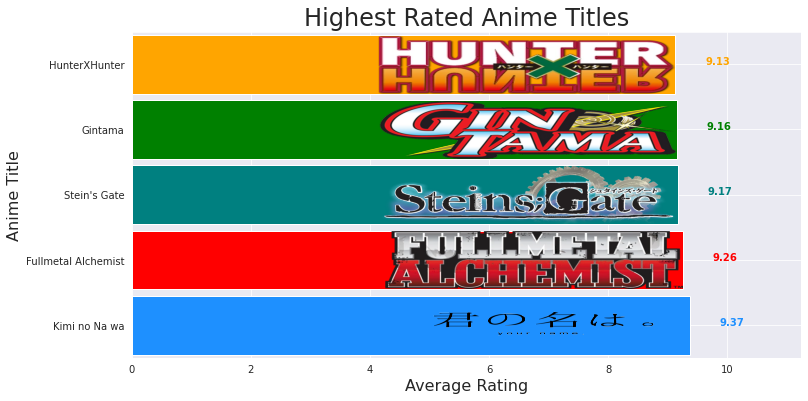

In [13]:
df_pop = (df_item[['name', 'rating']]).set_index('name')[:5]

labels = ['Kimi no Na wa','Fullmetal Alchemist', "Stein's Gate", 'Gintama',
          'HunterXHunter']
colors = ['dodgerblue', 'red', 'teal', 'green', 'orange']
# colors = ['crimson', 'dodgerblue', 'teal']
values = df_pop.rating.values

height = 0.9
plt.figure(figsize=(12, 6))
plt.barh(y=labels, width=values, height=height, color=colors, align='center')

for i, (label, value) in enumerate(zip(labels, values)):
    # load the image corresponding to label into img
    img = iio.imread(f'top{i+1}.png')
    plt.imshow(img, extent=[value - 5, value, i - height / 2,
                            i + height / 2.1], aspect='auto', zorder=2)
plt.xlim(0, max(values) * 1.2)
plt.ylim(-0.5, len(labels) - 0.5)
for i, v in enumerate(values):
    plt.text(v+.5, i, str(v), color=colors[i], fontweight='bold')
plt.title('Highest Rated Anime Titles',
          fontdict={'fontsize': 24,
                  'verticalalignment': 'baseline'})
plt.xlabel("Average Rating", fontsize=16)
plt.ylabel("Anime Title", fontsize=16)
plt.show()

<span style="font-size: 12px">
    <center>Figure 5. Top 5 Highly Rated Anime Titles</center>
</span>

<span style="font-size: 18px">
    <b>Action</b> and <b>Supernatural</b> are the genre with the highest rating count.
</span>

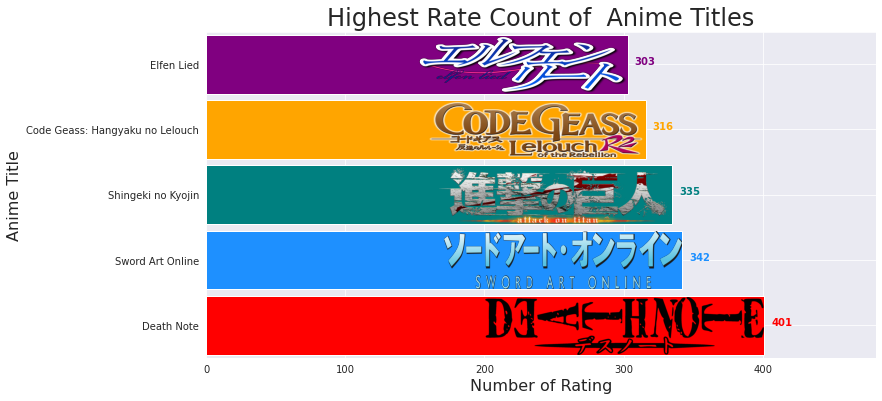

In [14]:
df_nrate = df_user.groupby('anime_id')['rating'].count()\
                                                .sort_values(ascending=False)

labels = df_name.loc[df_nrate.index[:5]]['name'].to_list()
colors = ['red', 'dodgerblue', 'teal', 'orange', 'purple']
# colors = ['crimson', 'dodgerblue', 'teal']
values = df_nrate[:5].values

height = 0.9
plt.figure(figsize=(12, 6))
plt.barh(y=labels, width=values, height=height, color=colors, align='center')

for i, (label, value) in enumerate(zip(labels, values)):
    # load the image corresponding to label into img
    img = iio.imread(f'topn{i+1}.png')
    plt.imshow(img, extent=[value / 2, value, i - height / 2,
                            i + height / 2.1], aspect='auto', zorder=2)
plt.xlim(0, max(values) * 1.2)
plt.ylim(-0.5, len(labels) - 0.5)
for i, v in enumerate(values):
    plt.text(v+5, i, str(v), color=colors[i], fontweight='bold')
plt.title('Highest Rate Count of  Anime Titles',
          fontdict={'fontsize': 24,
                  'verticalalignment': 'baseline'})
plt.xlabel("Number of Rating", fontsize=16)
plt.ylabel("Anime Title", fontsize=16)
plt.show()

<span style="font-size: 12px">
    <center>Figure 6. Top 5 Anime Titles with Most Number of Ratings</center>
</span>

# Methodology

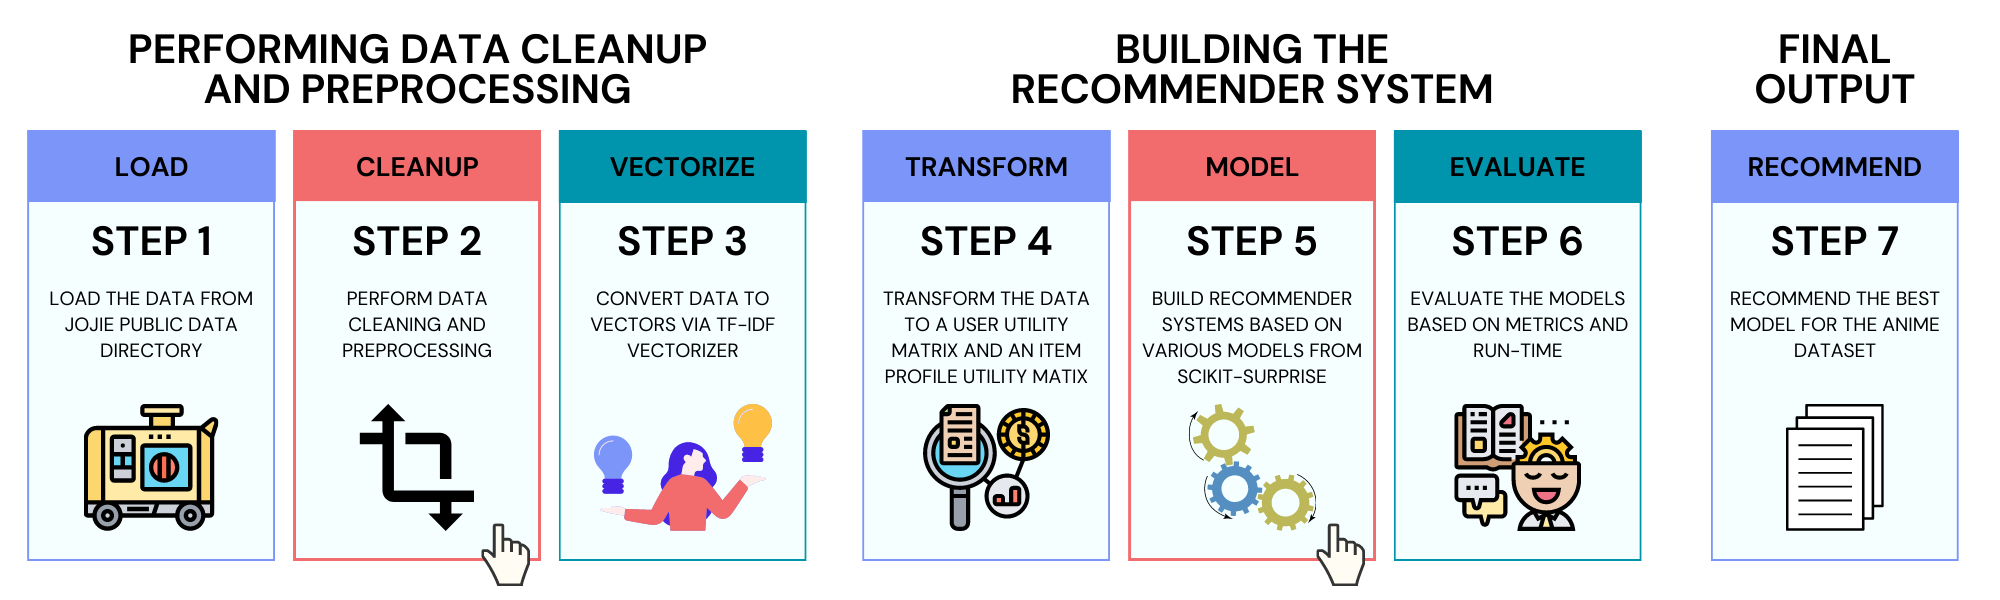

<span style="font-size: 12px">
    <center>Figure 7. Overview of the Methodology</center>
</span>

**1. Raw Data Exploration**
  - Examine data structure and characteristics
  - Check for null data
  - Check for unwanted outliers
  
**2. Data Cleaning and Preprocessing**
  - Perform null value imputation
  - Perform removal of duplicate data
  - Filter the `user` data to:
    * Users who rated more than 20 titles
    * Randomly sampled 1000 users
  - Filter the `title` data to:
    * Titles that are top 50 most subscribed anime titles
    * Titles with more than 11 episodes for TV type
    * Titles are not of type Music
    * Titles that have been rated by the selected users
  - Fix `user` and `title` utility matrix to reflect the same number of users:
    * 659 users
    * 4381 titles
    * 37 title features
  
**3. Data Vectorization**
  - Vectorize `title` data using TF-IDF vectorizer to convert the genre and type into features.
        
**4. Recommender System**
  - Create a recommender system using various collaborative filtering methods.
    * Baseline Model
    * User-based Collaborative Filtering
    * Item-based Collaborative Filtering
    * Latent Factor-based Collaborative Filtering
      + SVD
      + NMF
      + SVD++
    * Slope One-based Collaborative Filtering
    * Co-clustering-based Collaborative Filtering
  - Generating user recommendations for users
  - Comparison of Evaluation Metrics
    * Error Score (RMSE, MSE)
    * Coverage SCore
    * Novelty Score
    * Personalization Score
    * Intra-list Similarity Score
    * Run-Time
    * Metrics Radar Plot Summary

# Main Body

## Building the Recommender System

**What is a recommender system?**

A recommendation system is a subclass of Information filtering Systems that seeks to predict the rating or the preference a user might give to an item. In simple words, it is an algorithm that suggests relevant items to users. Eg: In the case of Netflix which movie to watch, In the case of e-commerce which product to buy, or In the case of kindle which book to read, etc. [2]

**Why are recommender systems important?**

Recommender systems are important because they help users discover and engage with content or products that are most relevant and interesting to them. In an era of information overload, recommender systems play a critical role in filtering and personalizing content for individual users.

**Here are some specific reasons why recommender systems are important:**

1. Personalization
2. Increased Sales and Revenue
3. Efficient Use of Resources
4. Enhanced User Experience

To summarize, recommender systems are powerful business tools that provide personalized recommendations to users. It helps users discover new content and products that they may not have found otherwise, while also driving sales and revenue for businesses.

There are many types of recommender systems and we can go all day talking about them. However, for this study, the team will choose the best type of recommender system out of the following:

1. Baseline Model
2. User-based Collaborative Filtering
3. Item-based Collaborative Filtering
4. Latent Factor-based Collaborative Filtering
  * SVD
  * NMF
  * SVD++
5. Slope One-based Collaborative Filtering
6. Co-clustering-based Collaborative Filtering

For this study, we will be using the Scikit-Surprise Library. The scikit-surprise library is a popular Python library for building recommender systems using collaborative filtering techniques. The algorithms we decided to use are baseline, user-based kNN, item-based kNN, SVD, NMD, SVD++, SlopeOne, and Co-Clustering. Here's a comparison of the user-based k-NN, item-based k-NN, and SVD algorithms in the scikit-surprise library:

1. **Baseline Model** - Algorithm predicting the baseline estimate for a given user and item.
2. **User-based kNNWithMeans** - A basic collaborative filtering algorithm, taking into account the mean ratings of each user and computes the similarities between users.
3. **Item-based kNNWithMeans** - A basic collaborative filtering algorithm, taking into account the mean ratings of each user and computes the similarities between items.
4. Matrix Factorization
  * **SVD** - The famous SVD algorithm, as popularized by Simon Funk during the Netflix Prize.
  * **NMF** - A collaborative filtering algorithm based on Non-negative Matrix Factorization.
  * **SVD++** - The SVD++ algorithm, an extension of SVD taking into account implicit ratings.
5. **Slope One** - A simple yet accurate collaborative filtering algorithm.
6. **Co-clustering** - A collaborative filtering algorithm based on co-clustering.

After implementing the aforementioned algorithms, we will then evaluate each model to identify which algorithm performs the best.

### Baseline Model

The baseline models makes use of an algorithm that predicts the baseline estimate for given user and item given below:

$${\hat{r}}_{ui}=b_{ui}=\mu+b_u+b_i$$

If user $\mu$ is unknown, then the bias $b_u$ is assumed to be zero. The same applies for item  $i$ with $b_i$. [3]

In [15]:
seed(1337)

df_melt = df_user.copy()
rating_scale = (0,10)
user_list = sample(df_user['user_id'].unique().tolist(), 5)

base_rec, base_pred, base_time = recsys_user(df_melt, rating_scale,
                                             user_list, df_name)
base_rec

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Evaluating R

70412  \
                                               Likes   
Top1                            Fate/Zero 2nd Season   
Top2                         Shigatsu wa Kimi no Uso   
Top3  Berserk: Ougon Jidai-hen II - Doldrey Kouryaku   
Top4     Berserk: Ougon Jidai-hen I - Haou no Tamago   
Top5           Berserk: Ougon Jidai-hen III - Kourin   

                                                        \
                                            Recommends   
Top1  Hajimari no Boukensha-tachi: Legend of Crystania   
Top2                              Ginga Eiyuu Densetsu   
Top3                                      Zetsuai 1989   
Top4                        Bronze: Zetsuai Since 1989   
Top5          Kimagure Orange☆Road: Ano Hi ni Kaeritai   

                                   61025  \
                                   Likes   
Top1              Natsume Yuujinchou San   
Top2  Final Fantasy VII: Advent Children   
Top3             Zoku Natsume Yuujinchou   
Top4                  Natsume Yuujinchou   
Top5                            Mushishi   

                                                        \
                                            Recommends   
Top1  Hajimari no Boukensha-tachi: Legend of Crystania   
Top2                              Ginga Eiyuu Densetsu   
Top3                                        Arete Hime   
Top4                        Bronze: Zetsuai Since 1989   
Top5          Kimagure Orange☆Road: Ano Hi ni Kaeritai   

                           40560                                   \
                           Likes                       Recommends   
Top1           Chibi Maruko-chan                     Cowboy Bebop   
Top2             Terra e... (TV)  Cowboy Bebop: Tengoku no Tobira   
Top3  Tengen Toppa Gurren Lagann                           Trigun   
Top4                Zoids Fuzors                     Eyeshield 21   
Top5              B&#039;T X Neo             Hachimitsu to Clover   

                                                  65174  \
                                                  Likes   
Top1  Danganronpa 3: The End of Kibougamine Gakuen -...   
Top2                                   Plastic Memories   
Top3                            Shigatsu wa Kimi no Uso   
Top4  Yahari Ore no Seishun Love Comedy wa Machigatt...   
Top5                   Utawarerumono: Itsuwari no Kamen   

                                                         \
                                             Recommends   
Top1                               Hachimitsu to Clover   
Top2                                            Monster   
Top3                                         Texhnolyze   
Top4  Rurouni Kenshin: Meiji Kenkaku Romantan - Tsui...   
Top5                                               Beck   

                              66934  \
                              Likes   
Top1             Ghost in the Shell   
Top2    Sakigake!! Cromartie Koukou   
Top3  Suzumiya Haruhi no Shoushitsu   
Top4     Suzumiya Haruhi no Yuuutsu   
Top5       Sayonara Zetsubou Sensei   

                                                        
                                            Recommends  
Top1  Hajimari no Boukensha-tachi: Legend of Crystania  
Top2                              Ginga Eiyuu Densetsu  
Top3          Kimagure Orange☆Road: Ano Hi ni Kaeritai  
Top4                                      Dash! Kappei  
Top5                       Ayatsuri Haramase DreamNote

In [16]:
df_base_pred = pd.DataFrame(base_pred)
df_base_pred.drop("details", inplace=True, axis=1)
df_base_pred.columns = ['user_id', 'anime_id', 'actual', 'user_predictions']
df_base_pred.head()
base_mse = recmetrics.mse(df_base_pred.actual, df_base_pred.user_predictions)
base_rmse = recmetrics.rmse(df_base_pred.actual,
                            df_base_pred.user_predictions)
print("MSE: ", base_mse)
print("RMSE: ", base_rmse)

MSE:  1.4999802656896488
RMSE:  1.2247368148666262


In [17]:
base_model = df_base_pred.pivot_table(index='user_id', columns='anime_id',
                                      values='user_predictions').fillna(0)

df_base_pred = df_base_pred.copy().groupby('user_id',as_index=False)\
                        ['anime_id'].agg({'actual': (lambda x: list(set(x)))})
df_base_pred = df_base_pred.set_index("user_id")

base_recs = [] = []
for user in df_base_pred.index:
    base_predictions = get_users_predictions(user, 10, base_model)
    base_recs.append(base_predictions)
        
df_base_pred['user_predictions'] = base_recs

catalog = df_melt.anime_id.unique().tolist()
base_coverage = recmetrics.prediction_coverage(base_recs, catalog)
print("Coverage: ", base_coverage)

Coverage:  11.02


### User-based Collaborative Filtering

This algorithm is an implementation of user-based collaborative filtering using k-NN. It computes similarities between users and uses the k-nearest neighbors to make recommendations. 

The prediction ${\hat{r}}_{ui}$ is set as:

$${\hat{r}}_{ui}=\mu_u+\frac{\sum_{v\in N_i^k\left(u\right)}{sim\left(u,v\right)\bullet\left(r_{vi}-\mu_v\right)}}{\sum_{v\in N_i^k\left(u\right)}sim\left(u,v\right)}$$

$$or$$

$${\hat{r}}_{ui}=\mu_i+\frac{\sum_{j\in N_u^k\left(i\right)}{sim\left(i,j\right)\bullet\left(r_{uj}-\mu_j\right)}}{\sum_{j\in N_u^k\left(i\right)}sim\left(i,j\right)}$$

depending on the `user_based` field of the `sim_options` parameter. [3]

User-based k-NN can be fast and effective for small to medium-sized datasets but can suffer from scalability and sparsity issues for larger datasets.

In [18]:
user_rec, user_pred, user_time = recsys_user(df_melt, rating_scale,
                                             user_list, df_name)
user_rec

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Evaluating R

70412  \
                                               Likes   
Top1                            Fate/Zero 2nd Season   
Top2                         Shigatsu wa Kimi no Uso   
Top3  Berserk: Ougon Jidai-hen II - Doldrey Kouryaku   
Top4     Berserk: Ougon Jidai-hen I - Haou no Tamago   
Top5           Berserk: Ougon Jidai-hen III - Kourin   

                                                        \
                                            Recommends   
Top1  Hajimari no Boukensha-tachi: Legend of Crystania   
Top2                              Ginga Eiyuu Densetsu   
Top3                                      Zetsuai 1989   
Top4                        Bronze: Zetsuai Since 1989   
Top5          Kimagure Orange☆Road: Ano Hi ni Kaeritai   

                                   61025  \
                                   Likes   
Top1              Natsume Yuujinchou San   
Top2  Final Fantasy VII: Advent Children   
Top3             Zoku Natsume Yuujinchou   
Top4                  Natsume Yuujinchou   
Top5                            Mushishi   

                                                        \
                                            Recommends   
Top1  Hajimari no Boukensha-tachi: Legend of Crystania   
Top2                              Ginga Eiyuu Densetsu   
Top3                                        Arete Hime   
Top4                        Bronze: Zetsuai Since 1989   
Top5          Kimagure Orange☆Road: Ano Hi ni Kaeritai   

                           40560                                   \
                           Likes                       Recommends   
Top1           Chibi Maruko-chan                     Cowboy Bebop   
Top2             Terra e... (TV)  Cowboy Bebop: Tengoku no Tobira   
Top3  Tengen Toppa Gurren Lagann                           Trigun   
Top4                Zoids Fuzors                     Eyeshield 21   
Top5              B&#039;T X Neo             Hachimitsu to Clover   

                                                  65174  \
                                                  Likes   
Top1  Danganronpa 3: The End of Kibougamine Gakuen -...   
Top2                                   Plastic Memories   
Top3                            Shigatsu wa Kimi no Uso   
Top4  Yahari Ore no Seishun Love Comedy wa Machigatt...   
Top5                   Utawarerumono: Itsuwari no Kamen   

                                                         \
                                             Recommends   
Top1                               Hachimitsu to Clover   
Top2                                            Monster   
Top3                                         Texhnolyze   
Top4  Rurouni Kenshin: Meiji Kenkaku Romantan - Tsui...   
Top5                                               Beck   

                              66934  \
                              Likes   
Top1             Ghost in the Shell   
Top2    Sakigake!! Cromartie Koukou   
Top3  Suzumiya Haruhi no Shoushitsu   
Top4     Suzumiya Haruhi no Yuuutsu   
Top5       Sayonara Zetsubou Sensei   

                                                        
                                            Recommends  
Top1  Hajimari no Boukensha-tachi: Legend of Crystania  
Top2                              Ginga Eiyuu Densetsu  
Top3          Kimagure Orange☆Road: Ano Hi ni Kaeritai  
Top4                                      Dash! Kappei  
Top5                       Ayatsuri Haramase DreamNote

<span style="font-size: 12px">
    <center>Table 11. Overview of Likes and Recommendation for User-Based Collaborative Filtering</center>
</span>

In [19]:
df_user_pred = pd.DataFrame(user_pred)
df_user_pred.drop("details", inplace=True, axis=1)
df_user_pred.columns = ['user_id', 'anime_id', 'actual', 'user_predictions']
df_user_pred.head()
user_mse = recmetrics.mse(df_user_pred.actual, df_user_pred.user_predictions)
user_rmse = recmetrics.rmse(df_user_pred.actual,
                            df_user_pred.user_predictions)
print("MSE: ", user_mse)
print("RMSE: ", user_rmse)

MSE:  1.4999802656896488
RMSE:  1.2247368148666262


In [20]:
user_model = df_user_pred.pivot_table(index='user_id', columns='anime_id',
                                      values='user_predictions').fillna(0)

df_user_pred = df_user_pred.copy().groupby('user_id',as_index=False)\
                        ['anime_id'].agg({'actual': (lambda x: list(set(x)))})
df_user_pred = df_user_pred.set_index("user_id")

user_recs = [] = []
for user in df_user_pred.index:
    user_predictions = get_users_predictions(user, 10, user_model)
    user_recs.append(user_predictions)
        
df_user_pred['user_predictions'] = user_recs

catalog = df_melt.anime_id.unique().tolist()
user_coverage = recmetrics.prediction_coverage(user_recs, catalog)
print("Coverage: ", user_coverage)

Coverage:  11.02


### Item-based Collaborative Filtering

This algorithm is an implementation of item-based collaborative filtering using k-NN. It computes similarities between items and uses the k-nearest neighbors to make recommendations. 

The prediction ${\hat{r}}_{ui}$ is set as:

$${\hat{r}}_{ui}=\mu_u+\frac{\sum_{v\in N_i^k\left(u\right)}{sim\left(u,v\right)\bullet\left(r_{vi}-\mu_v\right)}}{\sum_{v\in N_i^k\left(u\right)}sim\left(u,v\right)}$$

$$or$$

$${\hat{r}}_{ui}=\mu_i+\frac{\sum_{j\in N_u^k\left(i\right)}{sim\left(i,j\right)\bullet\left(r_{uj}-\mu_j\right)}}{\sum_{j\in N_u^k\left(i\right)}sim\left(i,j\right)}$$

depending on the `user_based` field of the `sim_options` parameter. [3]

Item-based k-NN can be faster and more scalable than user-based k-NN and can handle sparsity better. However, it may not work as well for datasets with a large number of items.

In [21]:
item_rec, item_pred, item_time = recsys_item(df_melt, rating_scale,
                                             user_list, df_name)
item_rec

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Evaluating R

70412  \
                                               Likes   
Top1                            Fate/Zero 2nd Season   
Top2                         Shigatsu wa Kimi no Uso   
Top3  Berserk: Ougon Jidai-hen II - Doldrey Kouryaku   
Top4     Berserk: Ougon Jidai-hen I - Haou no Tamago   
Top5           Berserk: Ougon Jidai-hen III - Kourin   

                                                                       61025  \
                              Recommends                               Likes   
Top1                Ginga Eiyuu Densetsu              Natsume Yuujinchou San   
Top2                     Guardian Hearts  Final Fantasy VII: Advent Children   
Top3     Shin Chou Kyou Ryo: Condor Hero             Zoku Natsume Yuujinchou   
Top4  Shin Chou Kyou Ryo: Condor Hero II                  Natsume Yuujinchou   
Top5                          Arete Hime                            Mushishi   

                                                               40560  \
                              Recommends                       Likes   
Top1                     Guardian Hearts           Chibi Maruko-chan   
Top2     Shin Chou Kyou Ryo: Condor Hero             Terra e... (TV)   
Top3  Shin Chou Kyou Ryo: Condor Hero II  Tengen Toppa Gurren Lagann   
Top4                          Arete Hime                Zoids Fuzors   
Top5          Bronze: Zetsuai Since 1989              B&#039;T X Neo   

                                                         \
                                             Recommends   
Top1                                       Cowboy Bebop   
Top2                               Hachimitsu to Clover   
Top3                                            Monster   
Top4                                 Ghost in the Shell   
Top5  Rurouni Kenshin: Meiji Kenkaku Romantan - Tsui...   

                                                  65174  \
                                                  Likes   
Top1  Danganronpa 3: The End of Kibougamine Gakuen -...   
Top2                                   Plastic Memories   
Top3                            Shigatsu wa Kimi no Uso   
Top4  Yahari Ore no Seishun Love Comedy wa Machigatt...   
Top5                   Utawarerumono: Itsuwari no Kamen   

                                                         \
                                             Recommends   
Top1                                            Monster   
Top2  Rurouni Kenshin: Meiji Kenkaku Romantan - Tsui...   
Top3                                      Mononoke Hime   
Top4                      Sen to Chihiro no Kamikakushi   
Top5                              Great Teacher Onizuka   

                              66934                                      
                              Likes                          Recommends  
Top1             Ghost in the Shell                     Guardian Hearts  
Top2    Sakigake!! Cromartie Koukou     Shin Chou Kyou Ryo: Condor Hero  
Top3  Suzumiya Haruhi no Shoushitsu  Shin Chou Kyou Ryo: Condor Hero II  
Top4     Suzumiya Haruhi no Yuuutsu                          Arete Hime  
Top5       Sayonara Zetsubou Sensei          Bronze: Zetsuai Since 1989

<span style="font-size: 12px">
    <center>Table 12. Overview of Likes and Recommendation for Item-Based Collaborative Filtering</center>
</span>

In [22]:
df_item_pred = pd.DataFrame(item_pred)
df_item_pred.drop("details", inplace=True, axis=1)
df_item_pred.columns = ['user_id', 'anime_id', 'actual', 'user_predictions']
df_item_pred.head()
item_mse = recmetrics.mse(df_item_pred.actual, df_item_pred.user_predictions)
item_rmse = recmetrics.rmse(df_item_pred.actual,
                            df_item_pred.user_predictions)

print("MSE: ", item_mse)
print("RMSE: ", item_rmse)

MSE:  1.7834313641336323
RMSE:  1.3354517453407413


In [23]:
item_model = df_item_pred.pivot_table(index='user_id', columns='anime_id',
                                      values='user_predictions').fillna(0)

df_item_pred = df_item_pred.copy().groupby('user_id', as_index=False)\
                        ['anime_id'].agg({'actual': (lambda x: list(set(x)))})
df_item_pred = df_item_pred.set_index("user_id")

item_recs = [] = []
for user in df_item_pred.index:
    item_predictions = get_users_predictions(user, 10, item_model)
    item_recs.append(item_predictions)
        
df_item_pred['user_predictions'] = item_recs

catalog = df_melt.anime_id.unique().tolist()
item_coverage = recmetrics.prediction_coverage(item_recs, catalog)
print("Coverage: ", item_coverage)

Coverage:  7.42


### Latent-Factor-based Collaborative Filtering

#### SVD Algorithm

The SVD algorithm, as popularized by Simon Funk during the Netflix Prize, is a latent factor-based collaborative filtering algorithm that uses matrix factorization to learn latent factors that capture user preferences and item characteristics. 

The prediction ${\hat{r}}_{ui}$ is set as:

$${\hat{r}}_{ui}=\mu+b_u+b_i+Q_i^Tp_u$$

If user $u$ is unknown, then the bias $b_u$ and the factors $p_u$ are assumed to be zero. The same applies for item $i$ with $b_i$ and $q_i$.

To estimate all the unknown, we minimize the following regularized squared error:

$$\sum_{r_{ui} \in R_{train}} \left(r_{ui} - \hat{r}_{ui} \right)^2 +
\lambda\left(b_i^2 + b_u^2 + ||q_i||^2 + ||p_u||^2\right)$$

The minimization is performed by a very straightforward stochastic gradient descent:

$$\begin{split}b_u &\leftarrow b_u &+ \gamma (e_{ui} - \lambda b_u)\\
b_i &\leftarrow b_i &+ \gamma (e_{ui} - \lambda b_i)\\
p_u &\leftarrow p_u &+ \gamma (e_{ui} \cdot q_i - \lambda p_u)\\
q_i &\leftarrow q_i &+ \gamma (e_{ui} \cdot p_u - \lambda q_i)\end{split}$$

where $e_{ui} = r_{ui} - \hat{r}_{ui}$. [3]

It can handle large datasets and sparse data well and can be more accurate than k-NN methods in many cases. However, it can be slower to train and can be more difficult to interpret.

In [24]:
svd_rec, svd_pred, svd_time = recsys_svd(df_melt, rating_scale,
                                         user_list, df_name)
svd_rec

Evaluating RMSE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    1.2754  1.2860  1.2741  1.2785  0.0053  
Fit time          1.59    1.62    1.38    1.53    0.11    
Test time         0.20    0.20    0.20    0.20    0.00    


70412                        \
                                               Likes            Recommends   
Top1                            Fate/Zero 2nd Season         Gintama&#039;   
Top2                         Shigatsu wa Kimi no Uso               Monster   
Top3  Berserk: Ougon Jidai-hen II - Doldrey Kouryaku        Kimi no Na wa.   
Top4     Berserk: Ougon Jidai-hen I - Haou no Tamago               Gintama   
Top5           Berserk: Ougon Jidai-hen III - Kourin  Clannad: After Story   

                                   61025                                    \
                                   Likes                        Recommends   
Top1              Natsume Yuujinchou San                     Gintama&#039;   
Top2  Final Fantasy VII: Advent Children  Fullmetal Alchemist: Brotherhood   
Top3             Zoku Natsume Yuujinchou            Hunter x Hunter (2011)   
Top4                  Natsume Yuujinchou                           Monster   
Top5                            Mushishi                    Kimi no Na wa.   

                           40560                 \
                           Likes     Recommends   
Top1           Chibi Maruko-chan        Monster   
Top2             Terra e... (TV)       Mushishi   
Top3  Tengen Toppa Gurren Lagann        Gintama   
Top4                Zoids Fuzors    Steins;Gate   
Top5              B&#039;T X Neo  Gintama&#039;   

                                                  65174  \
                                                  Likes   
Top1  Danganronpa 3: The End of Kibougamine Gakuen -...   
Top2                                   Plastic Memories   
Top3                            Shigatsu wa Kimi no Uso   
Top4  Yahari Ore no Seishun Love Comedy wa Machigatt...   
Top5                   Utawarerumono: Itsuwari no Kamen   

                                                                66934  \
                            Recommends                          Likes   
Top1  Fullmetal Alchemist: Brotherhood             Ghost in the Shell   
Top2                     Gintama&#039;    Sakigake!! Cromartie Koukou   
Top3            Hunter x Hunter (2011)  Suzumiya Haruhi no Shoushitsu   
Top4                           Monster     Suzumiya Haruhi no Yuuutsu   
Top5                    Kimi no Na wa.       Sayonara Zetsubou Sensei   

                                        
                            Recommends  
Top1  Fullmetal Alchemist: Brotherhood  
Top2                     Gintama&#039;  
Top3            Hunter x Hunter (2011)  
Top4                           Monster  
Top5                    Kimi no Na wa.

<span style="font-size: 12px">
    <center>Table 13. Overview of Likes and Recommendation for Latent Factor-Based Collaborative Filtering</center>
</span>

In [25]:
df_svd_pred = pd.DataFrame(svd_pred)
df_svd_pred.drop("details", inplace=True, axis=1)
df_svd_pred.columns = ['user_id', 'anime_id', 'actual', 'user_predictions']
df_svd_pred.head()
svd_mse = recmetrics.mse(df_svd_pred.actual, df_svd_pred.user_predictions)
svd_rmse = recmetrics.rmse(df_svd_pred.actual, df_svd_pred.user_predictions)

print("MSE: ", svd_mse)
print("RMSE: ", svd_rmse)

MSE:  0.31527458942064984
RMSE:  0.5614931784275298


In [26]:
svd_model = df_svd_pred.pivot_table(index='user_id', columns='anime_id',
                                    values='user_predictions').fillna(0)

df_svd_pred = df_svd_pred.copy().groupby('user_id', as_index=False)\
                        ['anime_id'].agg({'actual': (lambda x: list(set(x)))})
df_svd_pred = df_svd_pred.set_index("user_id")

svd_recs = [] = []
for user in df_svd_pred.index:
    svd_predictions = get_users_predictions(user, 10, svd_model)
    svd_recs.append(svd_predictions)
        
df_svd_pred['user_predictions'] = svd_recs

catalog = df_melt.anime_id.unique().tolist()
svd_coverage = recmetrics.prediction_coverage(svd_recs, catalog)
print("Coverage: ", svd_coverage)

Coverage:  1.3


#### NMF Algorithm

The NMF algorithm is a collaborative filtering algorithm based on Non-negative Matrix Factorization.

This algorithm is very similar to SVD. The prediction $\hat{r}_{ui}$ is set as:

$$\hat{r}_{ui} = q_i^Tp_u,$$

where user and item factors are kept positive.

he optimization procedure is a (regularized) stochastic gradient descent with a specific choice of step size that ensures non-negativity of factors, provided that their initial values are also positive.

At each step of the SGD procedure, the factors $f$ or user $u$ and item $i$ are updated as follows:

$$\begin{split}p_{uf} &\leftarrow p_{uf} &\cdot \frac{\sum_{i \in I_u} q_{if}
\cdot r_{ui}}{\sum_{i \in I_u} q_{if} \cdot \hat{r_{ui}} +
\lambda_u |I_u| p_{uf}}\\
q_{if} &\leftarrow q_{if} &\cdot \frac{\sum_{u \in U_i} p_{uf}
\cdot r_{ui}}{\sum_{u \in U_i} p_{uf} \cdot \hat{r_{ui}} +
\lambda_i |U_i| q_{if}}\\\end{split}$$

where $\lambda_u$ and $\lambda_i$ are regularization parameters. [3]

In [27]:
nmf_rec, nmf_pred, nmf_time = recsys_nmf(df_melt, rating_scale,
                                         user_list, df_name)
nmf_rec

Evaluating RMSE of algorithm NMF on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    1.7897  1.7853  1.7721  1.7824  0.0075  
Fit time          3.95    3.86    3.65    3.82    0.13    
Test time         0.15    0.17    0.15    0.16    0.01    


70412                        \
                                               Likes            Recommends   
Top1                            Fate/Zero 2nd Season  Ginga Eiyuu Densetsu   
Top2                         Shigatsu wa Kimi no Uso    Rose of Versailles   
Top3  Berserk: Ougon Jidai-hen II - Doldrey Kouryaku   Heartcatch Precure!   
Top4     Berserk: Ougon Jidai-hen I - Haou no Tamago  Aria The Origination   
Top5           Berserk: Ougon Jidai-hen III - Kourin                Muumin   

                                   61025  \
                                   Likes   
Top1              Natsume Yuujinchou San   
Top2  Final Fantasy VII: Advent Children   
Top3             Zoku Natsume Yuujinchou   
Top4                  Natsume Yuujinchou   
Top5                            Mushishi   

                                                      \
                                          Recommends   
Top1                            Ginga Eiyuu Densetsu   
Top2  The iDOLM@STER Movie: Kagayaki no Mukougawa e!   
Top3                              Mobile Suit Gundam   
Top4                             Yuusha-Ou GaoGaiGar   
Top5                                      SKET Dance   

                           40560                                     \
                           Likes                         Recommends   
Top1           Chibi Maruko-chan               Ginga Eiyuu Densetsu   
Top2             Terra e... (TV)                            Gintama   
Top3  Tengen Toppa Gurren Lagann  Mobile Police Patlabor: The Movie   
Top4                Zoids Fuzors          Yuusha-Ou GaoGaiGar Final   
Top5              B&#039;T X Neo                Uchuu Senkan Yamato   

                                                  65174  \
                                                  Likes   
Top1  Danganronpa 3: The End of Kibougamine Gakuen -...   
Top2                                   Plastic Memories   
Top3                            Shigatsu wa Kimi no Uso   
Top4  Yahari Ore no Seishun Love Comedy wa Machigatt...   
Top5                   Utawarerumono: Itsuwari no Kamen   

                                                         \
                                             Recommends   
Top1                               Ginga Eiyuu Densetsu   
Top2                                            Futabu!   
Top3                                        City Hunter   
Top4                                 Hanada Shounen-shi   
Top5  Aria The Natural: Sono Futatabi Deaeru Kiseki ...   

                              66934  \
                              Likes   
Top1             Ghost in the Shell   
Top2    Sakigake!! Cromartie Koukou   
Top3  Suzumiya Haruhi no Shoushitsu   
Top4     Suzumiya Haruhi no Yuuutsu   
Top5       Sayonara Zetsubou Sensei   

                                                         
                                             Recommends  
Top1                               Noragami Aragoto OVA  
Top2                                            Jin-Rou  
Top3  Yuusha-Ou GaoGaiGar Final Grand Glorious Gathe...  
Top4                               Ginga Eiyuu Densetsu  
Top5           Kimagure Orange☆Road: Ano Hi ni Kaeritai

<span style="font-size: 12px">
    <center>Table 14. Overview of Likes and Recommendation for NMF Algorithm</center>
</span>

In [28]:
df_nmf_pred = pd.DataFrame(nmf_pred)
df_nmf_pred.drop("details", inplace=True, axis=1)
df_nmf_pred.columns = ['user_id', 'anime_id', 'actual', 'user_predictions']
df_nmf_pred.head()
nmf_mse = recmetrics.mse(df_nmf_pred.actual, df_nmf_pred.user_predictions)
nmf_rmse = recmetrics.rmse(df_nmf_pred.actual, df_nmf_pred.user_predictions)

print("MSE: ", nmf_mse)
print("RMSE: ", nmf_rmse)


MSE:  4.277386603229286
RMSE:  2.0681843736063006


In [29]:
nmf_model = df_nmf_pred.pivot_table(index='user_id', columns='anime_id',
                                    values='user_predictions').fillna(0)

df_nmf_pred = df_nmf_pred.copy().groupby('user_id', as_index=False)\
                        ['anime_id'].agg({'actual': (lambda x: list(set(x)))})
df_nmf_pred = df_nmf_pred.set_index("user_id")

nmf_recs = [] = []
for user in df_nmf_pred.index:
    nmf_predictions = get_users_predictions(user, 10, nmf_model)
    nmf_recs.append(nmf_predictions)
        
df_nmf_pred['user_predictions'] = nmf_recs

catalog = df_melt.anime_id.unique().tolist()
nmf_coverage = recmetrics.prediction_coverage(nmf_recs, catalog)
print("Coverage: ", nmf_coverage)


Coverage:  9.45


#### SVD++ Algorithm

The SVD++ algorithm is an extension of SVD taking into account `implicit` ratings.

The prediction $\hat{r}_{ui}$ is set as:

$$\hat{r}_{ui} = \mu + b_u + b_i + q_i^T\left(p_u +
|I_u|^{-\frac{1}{2}} \sum_{j \in I_u}y_j\right)$$

Where the $y_j$ terms are a new set of item factors that capture implicit ratings. Here, an implicit rating describes the fact that a user $u$ rated an item $j$, regardless of the rating value.

If user $u$ is unknown, then the bias $b_u$ and the factors $p_u$ are assumed to be zero. The same applies for item $i$ with $b_i$, $q_i$, and $y_i$. [3]

This algorithm however is slow to train.

In [30]:
svdpp_rec, svdpp_pred, svdpp_time = recsys_svdpp(df_melt, rating_scale,
                                         user_list, df_name)
svdpp_rec

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Evaluating RMSE of algorithm SVDpp on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    1.2742  1.2768  1.2715  1.2742  0.0021  
Fit time          48.26   48.75   45.40   47.47   1.48    
Test time         3.81    3.60    3.41    3.61    0.16    


70412                        \
                                               Likes            Recommends   
Top1                            Fate/Zero 2nd Season         Gintama&#039;   
Top2                         Shigatsu wa Kimi no Uso  Ginga Eiyuu Densetsu   
Top3  Berserk: Ougon Jidai-hen II - Doldrey Kouryaku               Monster   
Top4     Berserk: Ougon Jidai-hen I - Haou no Tamago        Kimi no Na wa.   
Top5           Berserk: Ougon Jidai-hen III - Kourin               Gintama   

                                   61025                                    \
                                   Likes                        Recommends   
Top1              Natsume Yuujinchou San                     Gintama&#039;   
Top2  Final Fantasy VII: Advent Children              Ginga Eiyuu Densetsu   
Top3             Zoku Natsume Yuujinchou                           Monster   
Top4                  Natsume Yuujinchou  Fullmetal Alchemist: Brotherhood   
Top5                            Mushishi                    Kimi no Na wa.   

                           40560                        \
                           Likes            Recommends   
Top1           Chibi Maruko-chan               Monster   
Top2             Terra e... (TV)              Mushishi   
Top3  Tengen Toppa Gurren Lagann  Ginga Eiyuu Densetsu   
Top4                Zoids Fuzors               Gintama   
Top5              B&#039;T X Neo         Gintama&#039;   

                                                  65174  \
                                                  Likes   
Top1  Danganronpa 3: The End of Kibougamine Gakuen -...   
Top2                                   Plastic Memories   
Top3                            Shigatsu wa Kimi no Uso   
Top4  Yahari Ore no Seishun Love Comedy wa Machigatt...   
Top5                   Utawarerumono: Itsuwari no Kamen   

                                                                66934  \
                            Recommends                          Likes   
Top1                     Gintama&#039;             Ghost in the Shell   
Top2              Ginga Eiyuu Densetsu    Sakigake!! Cromartie Koukou   
Top3                           Monster  Suzumiya Haruhi no Shoushitsu   
Top4  Fullmetal Alchemist: Brotherhood     Suzumiya Haruhi no Yuuutsu   
Top5                    Kimi no Na wa.       Sayonara Zetsubou Sensei   

                                        
                            Recommends  
Top1                     Gintama&#039;  
Top2              Ginga Eiyuu Densetsu  
Top3                           Monster  
Top4  Fullmetal Alchemist: Brotherhood  
Top5                    Kimi no Na wa.

<span style="font-size: 12px">
    <center>Table 15. Overview of Likes and Recommendation for SVD++ Algorithm</center>
</span>

In [31]:
df_svdpp_pred = pd.DataFrame(svd_pred)
df_svdpp_pred.drop("details", inplace=True, axis=1)
df_svdpp_pred.columns = ['user_id', 'anime_id', 'actual', 'user_predictions']
df_svdpp_pred.head()
svdpp_mse = recmetrics.mse(df_svdpp_pred.actual,
                           df_svdpp_pred.user_predictions)
svdpp_rmse = recmetrics.rmse(df_svdpp_pred.actual,
                             df_svdpp_pred.user_predictions)

print("MSE: ", svdpp_mse)
print("RMSE: ", svdpp_rmse)

MSE:  0.31527458942064984
RMSE:  0.5614931784275298


In [32]:
svdpp_model = df_svdpp_pred.pivot_table(index='user_id', columns='anime_id',
                                        values='user_predictions').fillna(0)

df_svdpp_pred = df_svdpp_pred.copy().groupby('user_id', as_index=False)\
                        ['anime_id'].agg({'actual': (lambda x: list(set(x)))})
df_svdpp_pred = df_svdpp_pred.set_index("user_id")

svdpp_recs = [] = []
for user in df_svdpp_pred.index:
    svdpp_predictions = get_users_predictions(user, 10, svdpp_model)
    svdpp_recs.append(svdpp_predictions)
        
df_svdpp_pred['user_predictions'] = svdpp_recs

catalog = df_melt.anime_id.unique().tolist()
svdpp_coverage = recmetrics.prediction_coverage(svdpp_recs, catalog)
print("Coverage: ", svdpp_coverage)

Coverage:  1.3


### SlopeOne-based Collaborative Filtering

The Slope one algorithm is a simple yet accurate collaborative filtering algorithm.

The prediction $\hat{r}_{ui}$ is set as:

$$\hat{r}_{ui} = \mu_u + \frac{1}{
|R_i(u)|}
\sum\limits_{j \in R_i(u)} \text{dev}(i, j),$$

where $R_i(u)$ is the set of relevant items, i.e. the set of items $j$ rated by $u$ that also have at least one common user with $i$. $\text{dev}_(i, j)$ is defined as the average difference between the ratings of $i$ and those of $j$: [3]

$$\text{dev}(i, j) = \frac{1}{
|U_{ij}|}\sum\limits_{u \in U_{ij}} r_{ui} - r_{uj}$$

In [33]:
slp_rec, slp_pred, slp_time = recsys_slp(df_melt, rating_scale,
                                         user_list, df_name)
slp_rec

Evaluating RMSE of algorithm SlopeOne on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    1.2827  1.2829  1.2872  1.2843  0.0021  
Fit time          1.03    0.91    0.87    0.94    0.07    
Test time         2.15    2.54    2.12    2.27    0.19    


70412  \
                                               Likes   
Top1                            Fate/Zero 2nd Season   
Top2                         Shigatsu wa Kimi no Uso   
Top3  Berserk: Ougon Jidai-hen II - Doldrey Kouryaku   
Top4     Berserk: Ougon Jidai-hen I - Haou no Tamago   
Top5           Berserk: Ougon Jidai-hen III - Kourin   

                                                         \
                                             Recommends   
Top1                                 Rose of Versailles   
Top2                               Ginga Eiyuu Densetsu   
Top3                                  Hoshi wo Katta Hi   
Top4                                Genius Party Beyond   
Top5  Ghost in the Shell: Stand Alone Complex - Soli...   

                                   61025  \
                                   Likes   
Top1              Natsume Yuujinchou San   
Top2  Final Fantasy VII: Advent Children   
Top3             Zoku Natsume Yuujinchou   
Top4                  Natsume Yuujinchou   
Top5                            Mushishi   

                                                         \
                                             Recommends   
Top1                               Ginga Eiyuu Densetsu   
Top2  Tenchi Muyou! Ryououki: Omatsuri Zenjitsu no Y...   
Top3                      Seto no Hanayome OVA Specials   
Top4                             Cyborg 009 VS Devilman   
Top5                       Battle Athletess Daiundoukai   

                           40560                                   \
                           Likes                       Recommends   
Top1           Chibi Maruko-chan                     Cowboy Bebop   
Top2             Terra e... (TV)  Cowboy Bebop: Tengoku no Tobira   
Top3  Tengen Toppa Gurren Lagann                           Trigun   
Top4                Zoids Fuzors                     Eyeshield 21   
Top5              B&#039;T X Neo             Hachimitsu to Clover   

                                                  65174  \
                                                  Likes   
Top1  Danganronpa 3: The End of Kibougamine Gakuen -...   
Top2                                   Plastic Memories   
Top3                            Shigatsu wa Kimi no Uso   
Top4  Yahari Ore no Seishun Love Comedy wa Machigatt...   
Top5                   Utawarerumono: Itsuwari no Kamen   

                                                               66934  \
                           Recommends                          Likes   
Top1  Cowboy Bebop: Tengoku no Tobira             Ghost in the Shell   
Top2             Hachimitsu to Clover    Sakigake!! Cromartie Koukou   
Top3                          Monster  Suzumiya Haruhi no Shoushitsu   
Top4                       Texhnolyze     Suzumiya Haruhi no Yuuutsu   
Top5                          Berserk       Sayonara Zetsubou Sensei   

                                                         
                                             Recommends  
Top1      Harukanaru Toki no Naka de: Ajisai Yumegatari  
Top2                               Ginga Eiyuu Densetsu  
Top3     Lupin III: Episode 0 &quot;First Contact&quot;  
Top4  Harukanaru Toki no Naka de: Hachiyou Shou Spec...  
Top5     Harukanaru Toki no Naka de 3: Kurenai no Tsuki

<span style="font-size: 12px">
    <center>Table 16. Overview of Likes and Recommendation for Slope One-based Collaborative Filtering</center>
</span>

In [34]:
df_slp_pred = pd.DataFrame(slp_pred)
df_slp_pred.drop("details", inplace=True, axis=1)
df_slp_pred.columns = ['user_id', 'anime_id', 'actual', 'user_predictions']
df_slp_pred.head()
slp_mse = recmetrics.mse(df_slp_pred.actual, df_slp_pred.user_predictions)
slp_rmse = recmetrics.rmse(df_slp_pred.actual, df_slp_pred.user_predictions)

print("MSE: ", slp_mse)
print("RMSE: ", slp_rmse)


MSE:  2.005390811536892
RMSE:  1.4161182194777708


In [35]:
slp_model = df_slp_pred.pivot_table(index='user_id', columns='anime_id',
                                    values='user_predictions').fillna(0)

df_slp_pred = df_slp_pred.copy().groupby('user_id', as_index=False)\
                        ['anime_id'].agg({'actual': (lambda x: list(set(x)))})
df_slp_pred = df_slp_pred.set_index("user_id")

slp_recs = [] = []
for user in df_slp_pred.index:
    slp_predictions = get_users_predictions(user, 10, slp_model)
    slp_recs.append(slp_predictions)
        
df_slp_pred['user_predictions'] = slp_recs

catalog = df_melt.anime_id.unique().tolist()
slp_coverage = recmetrics.prediction_coverage(slp_recs, catalog)
print("Coverage: ", slp_coverage)


Coverage:  12.39


### Co-Clustering-based Collaborative Filtering

Co-clustering is a collaborative filtering algorithm based on co-clustering.

Basically, users and items are assigned some clusters $C_u$, $C_i$, and some co-clusters $C_{ui}$.

The prediction $\hat{r}_{ui}$ is set as:

$$\hat{r}_{ui} = \overline{C_{ui}} + (\mu_u - \overline{C_u}) + (\mu_i
- \overline{C_i}),$$

where $\overline{C_{ui}}$ is the average rating of co-cluster $C_{ui}$, $\overline{C_u}$ is the average rating of $u$'s cluster, and $\overline{C_i}$ is the average rating of $i$'s cluster. If the user is unknown, the prediction is $\hat{r}_{ui} = \mu_i$. If the item is unknown, the prediction is $\hat{r}_{ui} = \mu_u$. If both the user and the item are unknown, the prediction is $\hat{r}_{ui} = \mu$. [3]

In [36]:
ccl_rec, ccl_pred, ccl_time = recsys_ccl(df_melt, rating_scale,
                                         user_list, df_name)
ccl_rec


Evaluating RMSE of algorithm CoClustering on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    1.3257  1.3237  1.3265  1.3253  0.0012  
Fit time          0.77    0.77    0.70    0.75    0.03    
Test time         0.12    0.13    0.12    0.12    0.00    


70412  \
                                               Likes   
Top1                            Fate/Zero 2nd Season   
Top2                         Shigatsu wa Kimi no Uso   
Top3  Berserk: Ougon Jidai-hen II - Doldrey Kouryaku   
Top4     Berserk: Ougon Jidai-hen I - Haou no Tamago   
Top5           Berserk: Ougon Jidai-hen III - Kourin   

                                                                       61025  \
                              Recommends                               Likes   
Top1     Shin Chou Kyou Ryo: Condor Hero              Natsume Yuujinchou San   
Top2  Shin Chou Kyou Ryo: Condor Hero II  Final Fantasy VII: Advent Children   
Top3                          Arete Hime             Zoku Natsume Yuujinchou   
Top4                      B&#039;T X Neo                  Natsume Yuujinchou   
Top5                       Deltora Quest                            Mushishi   

                                                         \
                                             Recommends   
Top1                                    Guardian Hearts   
Top2                         Bronze: Zetsuai Since 1989   
Top3                                        Imouto Jiru   
Top4  Harukanaru Toki no Naka de: Hachiyou Shou Spec...   
Top5                                            Aniyome   

                           40560                                   \
                           Likes                       Recommends   
Top1           Chibi Maruko-chan                     Cowboy Bebop   
Top2             Terra e... (TV)  Cowboy Bebop: Tengoku no Tobira   
Top3  Tengen Toppa Gurren Lagann                           Trigun   
Top4                Zoids Fuzors                     Eyeshield 21   
Top5              B&#039;T X Neo             Hachimitsu to Clover   

                                                  65174  \
                                                  Likes   
Top1  Danganronpa 3: The End of Kibougamine Gakuen -...   
Top2                                   Plastic Memories   
Top3                            Shigatsu wa Kimi no Uso   
Top4  Yahari Ore no Seishun Love Comedy wa Machigatt...   
Top5                   Utawarerumono: Itsuwari no Kamen   

                                                         \
                                             Recommends   
Top1                                       Cowboy Bebop   
Top2                                       Eyeshield 21   
Top3                               Hachimitsu to Clover   
Top4                                            Monster   
Top5  Rurouni Kenshin: Meiji Kenkaku Romantan - Tsui...   

                              66934  \
                              Likes   
Top1             Ghost in the Shell   
Top2    Sakigake!! Cromartie Koukou   
Top3  Suzumiya Haruhi no Shoushitsu   
Top4     Suzumiya Haruhi no Yuuutsu   
Top5       Sayonara Zetsubou Sensei   

                                                         
                                             Recommends  
Top1                                    Guardian Hearts  
Top2                         Bronze: Zetsuai Since 1989  
Top3                                        Imouto Jiru  
Top4  Harukanaru Toki no Naka de: Hachiyou Shou Spec...  
Top5                                            Aniyome

<span style="font-size: 12px">
    <center>Table 17. Overview of Likes and Recommendation for Co-Clustering-based Collaborative Filtering</center>
</span>

In [37]:
df_ccl_pred = pd.DataFrame(ccl_pred)
df_ccl_pred.drop("details", inplace=True, axis=1)
df_ccl_pred.columns = ['user_id', 'anime_id', 'actual', 'user_predictions']
df_ccl_pred.head()
ccl_mse = recmetrics.mse(df_ccl_pred.actual, df_ccl_pred.user_predictions)
ccl_rmse = recmetrics.rmse(df_ccl_pred.actual, df_ccl_pred.user_predictions)

print("MSE: ", ccl_mse)
print("RMSE: ", ccl_rmse)


MSE:  1.8447840115530092
RMSE:  1.3582282619475303


In [38]:
ccl_model = df_ccl_pred.pivot_table(index='user_id', columns='anime_id',
                                    values='user_predictions').fillna(0)

df_ccl_pred = df_ccl_pred.copy().groupby('user_id', as_index=False)\
                        ['anime_id'].agg({'actual': (lambda x: list(set(x)))})
df_ccl_pred = df_ccl_pred.set_index("user_id")

ccl_recs = [] = []
for user in df_ccl_pred.index:
    ccl_predictions = get_users_predictions(user, 10, ccl_model)
    ccl_recs.append(ccl_predictions)
        
df_ccl_pred['user_predictions'] = ccl_recs

catalog = df_melt.anime_id.unique().tolist()
ccl_coverage = recmetrics.prediction_coverage(ccl_recs, catalog)
print("Coverage: ", ccl_coverage)


Coverage:  7.9


### Comparison of Evaluation Metrics

Now that we have finished building the three recommender systems, how do we compare them to each other?

There are debates about how to evaluate a recommender system or what KPIs should employ to make a good comparison. Recommender systems can be evaluated in many ways using several metrics where each metric group has its purpose. However, for this study, we will be comparing our recommender systems using the following metrics:

1. Errors (MSE and RMSE)
2. Coverage
3. Novelty
4. Personalization
5. Intra-list Similarity
6. Run-Time

#### Error Scores

Mean Squared Error (MSE) and Root Mean Squared Error (RMSE) are used to evaluate the accuracy of predicted values that such as ratings compared to the true value, y. These can also be used to evalaute the reconstruction of a ratings matrix. [3]

$$MSE=\frac{\sum_{i=1}^{N}\left(y_i-{\hat{y}}_i\right)^2}{N}$$

$$RMSE=\sqrt{\frac{\sum_{i=1}^{N}\left(y_i-{\hat{y}}_i\right)^2}{N}}$$

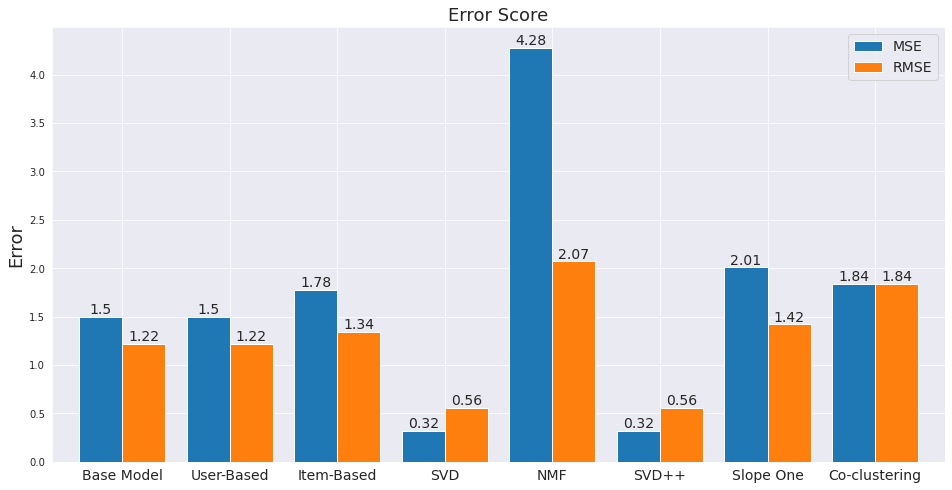

In [39]:

mse_scores = np.round([base_mse, user_mse, item_mse, svd_mse, nmf_mse,
              svdpp_mse, slp_mse, ccl_mse], 2)
rmse_scores = np.round([base_rmse, user_rmse, item_rmse, svd_rmse, nmf_rmse,
               svdpp_rmse, slp_rmse, ccl_mse], 2)
model_names = ['Base Model', 'User-Based', 'Item-Based', 'SVD',
               'NMF', 'SVD++', 'Slope One', 'Co-clustering']

df_error = pd.DataFrame({'MSE': mse_scores,
                   'RMSE': rmse_scores})
df_error['model'] = model_names
fig = df_error.plot(x='model', y=['MSE', 'RMSE'],
                    kind='bar', figsize=(16, 8), width=0.8)
fig.bar_label((fig.containers[0]), label_type='edge', fontsize=14)
fig.bar_label((fig.containers[1]), label_type='edge', fontsize=14)
fig.set_xlabel("")
fig.set_ylabel('Error', fontsize=18)
fig.set_xticklabels(model_names,fontsize=14)
fig.legend(fontsize=14)
plt.xticks(rotation=0)

fig.set_title('Error Score', fontsize=18);

<span style="font-size: 12px">
    <center>Figure 8. Bar Plot Comparing Error Scores between Different Methods of Recommender System</center>
</span>

#### Coverage Scores

Coverage is the percent of items in the training data the model can recommend on a test set.[4][5]

$$coverage=\frac{I}{N}\times100%$$

Where 'I' is the number of unique items the model recommends in the test data, and 'N' is the total number of unique items in the training data. The catalog coverage is the rate of distinct items recommended over a period of time to the user. For this purpose, the catalog coverage function take also as parameter 'k' the number of observed recommendation lists. In essence, both metrics quantify the proportion of items that the system can work with. [6]

To better understand this, say we have 100 items in our training data, and we set the number of recommendations=10 where the recommendations are always the same set of items for all users. Then this would mean that the coverage is only 10% since it only ever recommends the same 10 items from the original data. In math terms, it is the union of all user recommendations over the total number of items.

Here, the user-based collaborative filtering has an 9.18% coverage, while the item-based collaborative filtering is only able to recommend 6.05% of the items it was trained on. The recommender system with the lowest coverage is the latent factor-based collaborative filtering with 1.13% coverage.

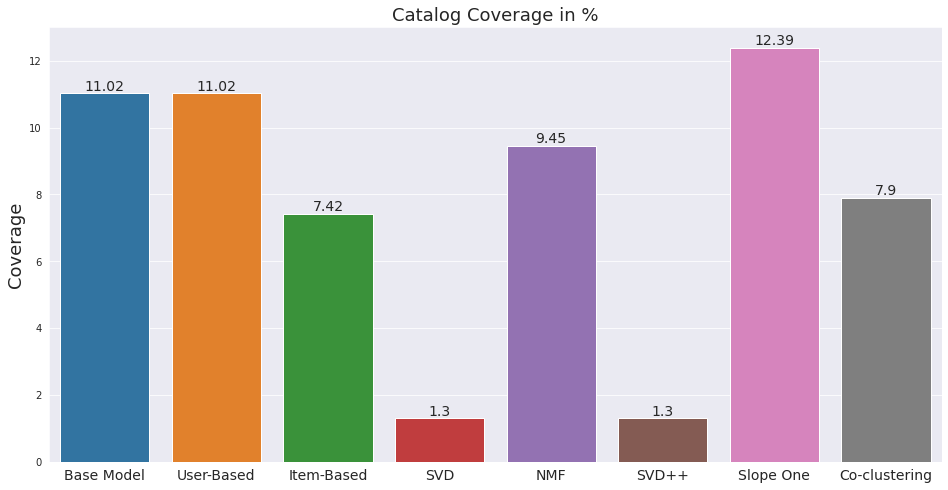

In [40]:
# plot of prediction coverage
coverage_scores = [base_coverage, user_coverage, item_coverage, svd_coverage,
                   nmf_coverage, svdpp_coverage, slp_coverage, ccl_coverage]
model_names = ['Base Model', 'User-Based', 'Item-Based', 'SVD',
               'NMF', 'SVD++', 'Slope One', 'Co-clustering']

fig = plt.figure(figsize=(16, 8))
fig = sns.barplot(x=model_names, y=coverage_scores)
fig.bar_label((fig.containers[0]), label_type='edge', fontsize=14)
fig.set_ylabel('Coverage', fontsize=18)
fig.set_xticklabels(model_names,fontsize=14)
fig.set_title('Catalog Coverage in %', fontsize=18);

<span style="font-size: 12px">
    <center>Figure 9. Bar Plot Comparing Coverage Scores between Different Methods of Recommender System</center>
</span>

#### Novelty Scores

Novelty measures the capacity of a recommender system to propose novel and unexpected items which a user is unlikely to know about already. It uses the self-information of the recommended item and it calculates the mean self-information per top-N recommended list and averages them over all users.[7]

$$novelty=\frac{1}{\left|U\right|}\sum_{\forall u\in U}\sum_{\forall i\in topN}\frac{\log_2\left(\frac{count\left(i\right)}{\left|U\right|}\right)}{\left|N\right|}$$

Where the absolute U is the number of users, count(i) is the number of users who consumed the specific item and N is the length of the recommended list.[8]

The novelty metric in recommender systems measures the degree to which recommended items are new and unexpected to the user. It is a way of quantifying how much the recommendations can introduce the user to new items that they have not previously encountered or considered. [9][10]

The novelty metric is important in recommender systems because it can help to prevent the problem of "filter bubbles," where users are only recommended items that align with their existing preferences and interests. By introducing users to new and unexpected items, recommender systems can help to broaden their horizons and expose them to new ideas and experiences. [8][10]

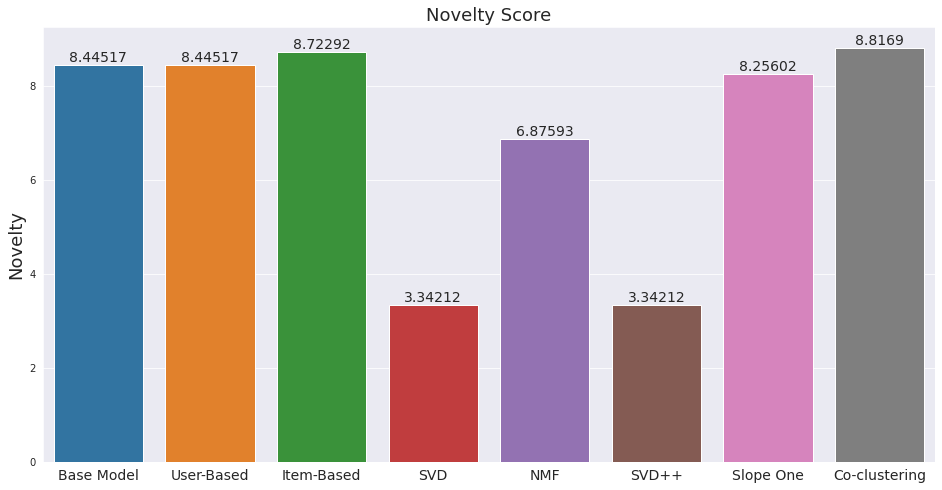

In [41]:
users = df_melt["user_id"].value_counts()
# users = users[users>=5].index.tolist()
users = users.index.tolist()

nov = df_melt.anime_id.value_counts()
pop = dict(nov)
# pop
base_novelty,base_mselfinfo_list = recmetrics.novelty(base_recs, pop,
                                                      len(users), 10)
user_novelty,user_mselfinfo_list = recmetrics.novelty(user_recs, pop,
                                                      len(users), 10)
item_novelty,item_mselfinfo_list = recmetrics.novelty(item_recs, pop,
                                                      len(users), 10)
svd_novelty,svd_mselfinfo_list = recmetrics.novelty(svd_recs, pop,
                                                    len(users), 10)
nmf_novelty,nmf_mselfinfo_list = recmetrics.novelty(nmf_recs, pop,
                                                    len(users), 10)
svdpp_novelty,svdpp_mselfinfo_list = recmetrics.novelty(svdpp_recs, pop,
                                                    len(users), 10)
slp_novelty,slp_mselfinfo_list = recmetrics.novelty(slp_recs, pop,
                                                    len(users), 10)
ccl_novelty,ccl_mselfinfo_list = recmetrics.novelty(ccl_recs, pop,
                                                    len(users), 10)


novelty_scores = [base_novelty, user_novelty, item_novelty, svd_novelty,
                  nmf_novelty, svdpp_novelty, slp_novelty, ccl_novelty]
model_names = ['Base Model', 'User-Based', 'Item-Based', 'SVD',
               'NMF', 'SVD++', 'Slope One', 'Co-clustering']

fig = plt.figure(figsize=(16, 8))
fig = sns.barplot(x=model_names, y=novelty_scores)
fig.bar_label(fig.containers[0], label_type='edge', fontsize=14)
fig.set_ylabel('Novelty', fontsize=18)
fig.set_xticklabels(model_names,fontsize=14)
fig.set_title('Novelty Score', fontsize=18);

<span style="font-size: 12px">
    <center>Figure 10. Bar Plot Comparing Novelty Scores between Different Methods of Recommender System</center>
</span>

#### Personalization Scores

Personalization is a great way to assess if a model recommends many of the same items to different users. It is the dissimilarity (1- cosine similarity) between user’s lists of recommendations. An example will best illustrate how personalization is calculated. [12]

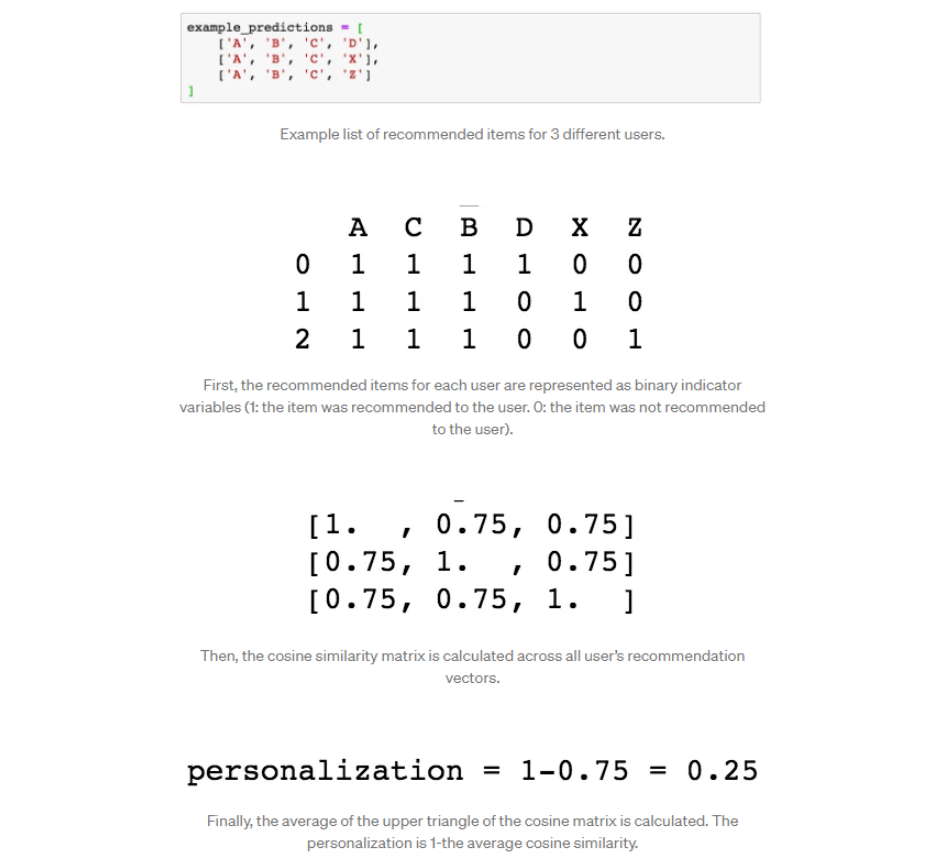
<span style="font-size: 12px">
    <center>Figure 11. Overview Explanation of Personalization Scores</center>
</span>

A high personalization score indicates user’s recommendations are different, meaning the model is offering a personalized experience to each user. [12]

**Summary:**
- A high score indicates good personalization (user's lists of recommendations are different). 
- A low score indicates poor personalization (user's lists of recommendations are very similar).
- A model is "personalizing" well if the set of recommendations for each user is different.[13]

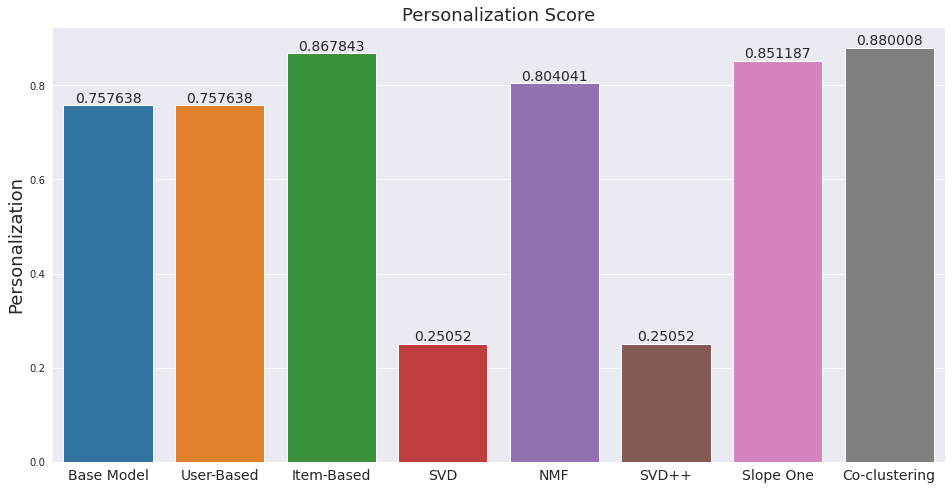

In [42]:
base_personal = recmetrics.personalization(predicted=base_recs)
user_personal = recmetrics.personalization(predicted=user_recs)
item_personal = recmetrics.personalization(predicted=item_recs)
svd_personal = recmetrics.personalization(predicted=svd_recs)
nmf_personal = recmetrics.personalization(predicted=nmf_recs)
svdpp_personal = recmetrics.personalization(predicted=svdpp_recs)
slp_personal = recmetrics.personalization(predicted=slp_recs)
ccl_personal = recmetrics.personalization(predicted=ccl_recs)

personal_scores = [base_personal, user_personal, item_personal, svd_personal,
                  nmf_personal, svdpp_personal, slp_personal, ccl_personal]
model_names = ['Base Model', 'User-Based', 'Item-Based', 'SVD',
               'NMF', 'SVD++', 'Slope One', 'Co-clustering']

fig = plt.figure(figsize=(16, 8))
fig = sns.barplot(x=model_names, y=personal_scores)
fig.bar_label(fig.containers[0], label_type='edge', fontsize=14)
fig.set_ylabel('Personalization', fontsize=18)
fig.set_xticklabels(model_names,fontsize=14)
fig.set_title('Personalization Score', fontsize=18);

<span style="font-size: 12px">
    <center>Figure 12. Bar Plot Comparing Personalization Scores between Different Methods of Recommender System</center>
</span>

#### Intra-list Similarity Scores

The intra-list similarity is the average cosine similarity of all items in a list of recommendations. This calculation uses features of the recommended items (such as movie genre) to calculate the similarity. This calculation is also best illustrated with an example. [14]

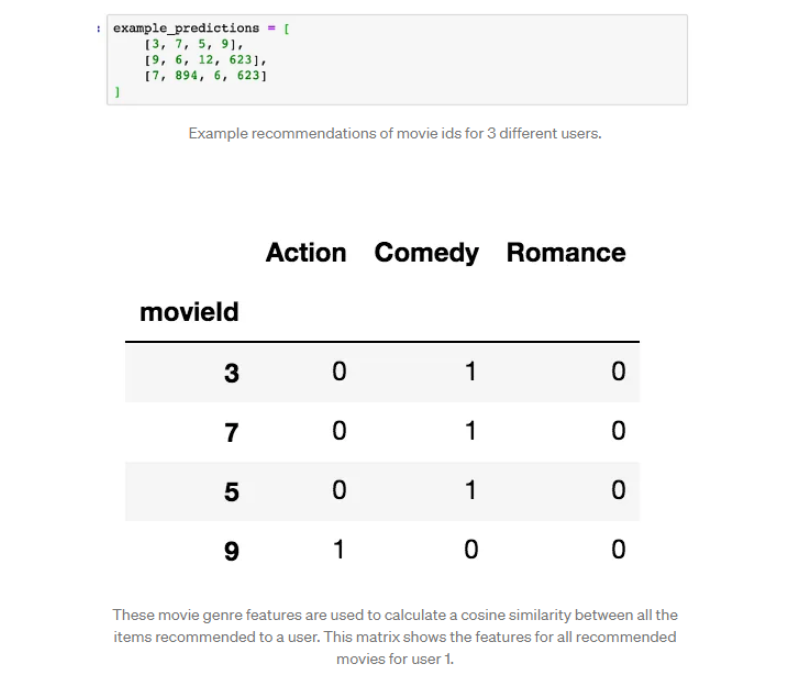

<span style="font-size: 12px">
    <center>Figure 13. Overview Explanation of Intra-list Similarity Score</center>
</span>


If a recommender system is recommending lists of very similar items to single users (for example, a user receives only recommendations of romance movies), then the intra-list similarity will be high. [15]

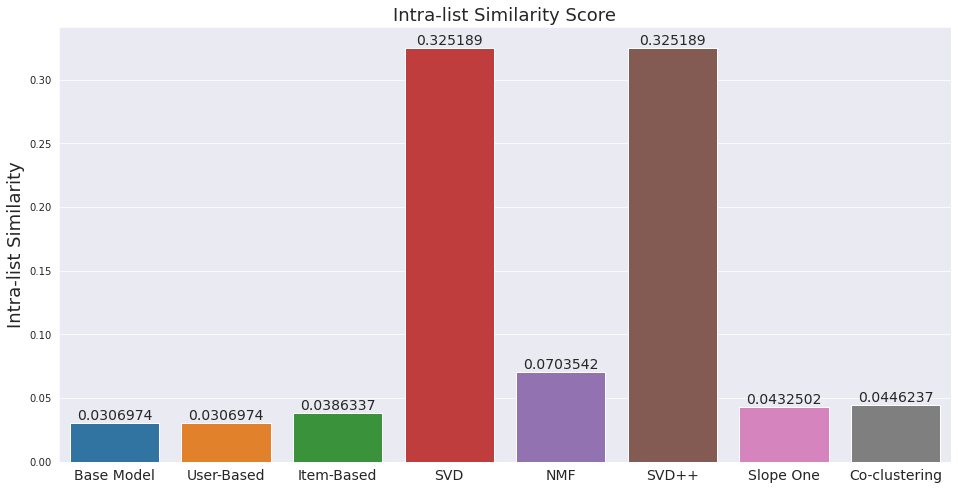

In [43]:
base_intra = recmetrics.intra_list_similarity(base_recs, df_anime)
user_intra = recmetrics.intra_list_similarity(user_recs, df_anime)
item_intra = recmetrics.intra_list_similarity(item_recs, df_anime)
svd_intra = recmetrics.intra_list_similarity(svd_recs, df_anime)
nmf_intra = recmetrics.intra_list_similarity(nmf_recs, df_anime)
svdpp_intra = recmetrics.intra_list_similarity(svdpp_recs, df_anime)
slp_intra = recmetrics.intra_list_similarity(slp_recs, df_anime)
ccl_intra = recmetrics.intra_list_similarity(ccl_recs, df_anime)

intra_scores = [base_intra, user_intra, item_intra, svd_intra,
                  nmf_intra, svdpp_intra, slp_intra, ccl_intra]
model_names = ['Base Model', 'User-Based', 'Item-Based', 'SVD',
               'NMF', 'SVD++', 'Slope One', 'Co-clustering']

fig = plt.figure(figsize=(16, 8))
fig = sns.barplot(x=model_names, y=intra_scores)
fig.bar_label(fig.containers[0], label_type='edge', fontsize=14)
fig.set_ylabel('Intra-list Similarity', fontsize=18)
fig.set_xticklabels(model_names,fontsize=14)
fig.set_title('Intra-list Similarity Score', fontsize=18);

<span style="font-size: 12px">
    <center>Figure 14. Bar Plot Comparing Intra-list Similarity Scores between Different Methods of Recommender System</center>
</span>

#### Model Run Time

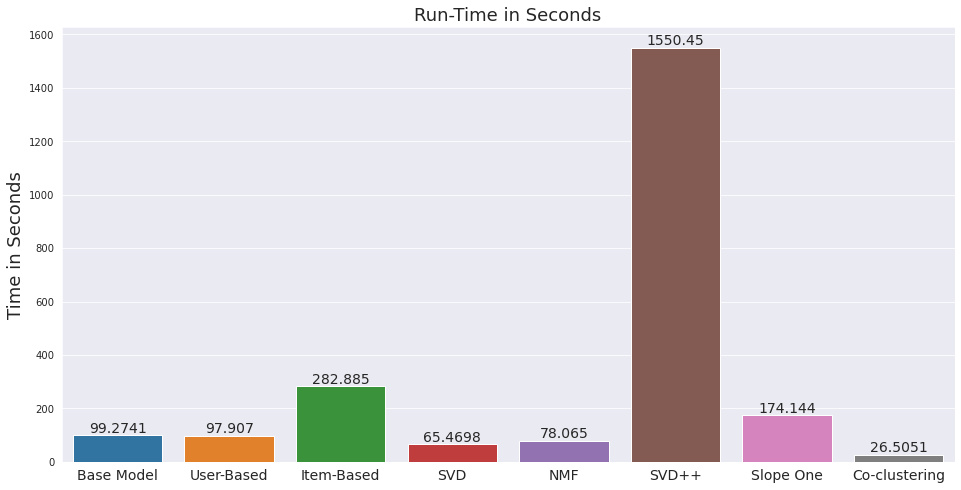

In [44]:
time_scores = [base_time, user_time, item_time, svd_time,
                  nmf_time, svdpp_time, slp_time, ccl_time]
model_names = ['Base Model', 'User-Based', 'Item-Based', 'SVD',
               'NMF', 'SVD++', 'Slope One', 'Co-clustering']

fig = plt.figure(figsize=(16, 8))
fig = sns.barplot(x=model_names, y=time_scores)
fig.bar_label(fig.containers[0], label_type='edge', fontsize=14)
fig.set_ylabel('Time in Seconds', fontsize=18)
fig.set_xticklabels(model_names,fontsize=14)
fig.set_title('Run-Time in Seconds', fontsize=18);

<span style="font-size: 12px">
    <center>Figure 15. Bar Plot Comparing Intra-list Similarity Scores between Different Methods of Recommender System</center>
</span>

#### Metrics Radar Plot Summary

Now that we have all the scores for each recommender system, let us compare them using a radar plot. Here, we compare the personalization, coverage, and intra-list similarity. The reason why novelty and error scores are not part of this radar plot is that they operate under a different scale and must be visualized differently. Regardless, let us proceed with the comparison using the radar plot.

How do we know that one model is outperforming the others? In a radar plot, the model that has the largest area is considered to be the best performing.

In [45]:
# recmetrics.metrics_plot(model_names=model_names,
#              coverage_scores=coverage_scores,
#              personalization_scores=personal_scores,
#              intra_list_similarity_scores = intra_scores)

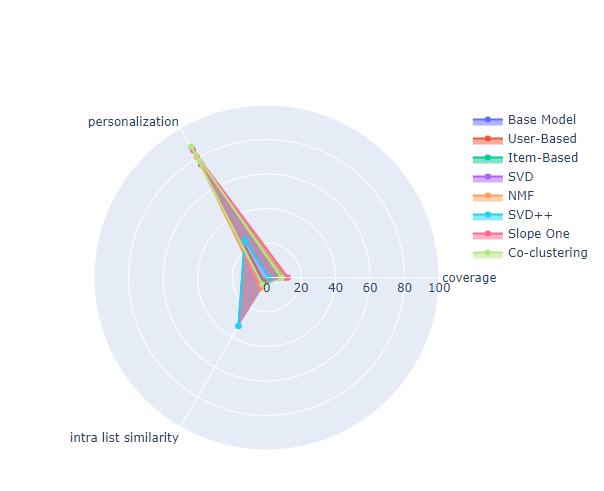

<span style="font-size: 12px">
    <center>Figure 16. Radar Plot Comparing Scores between Different Methods of Recommender System</center>
</span>

#### Metrics Table Summary

Unfortunately, the radar plot above does not give us a good picture of each model's performance. Instead, let's visualize it in tabular format.

Let us put all the values in a single table so we can compare the numbers. Let us summarize these metrics and put them into context:

1. **MSE and RMSE** - *Lower is better*. This measures the accuracy of the recommendations made by the system.
2. **Coverage** - *Higher is better*. This measures the proportion of items in the catalog that are recommended by the system. A high coverage indicates that the system can recommend a large number of items.
3. **Novelty** - *Contextual*. This measures the novelty of the recommendations made by the system. A high novelty indicates that the system recommends items that the user has not seen before. Users however may prefer a more balanced novelty.
4. **Personalization** - *Higher is better*. This measures how personalized the recommendations are for each user. A high personalization metric indicates that the recommendations are tailored to the individual user's preferences and needs, rather than being generic or popular recommendations.
5. **Intra-list-Similarity** - *Higher is better*. This measures the similarity between the items in a list of recommendations. A low intra-list similarity metric indicates that the recommendations are diverse and cover a wide range of items, while a high intra-list similarity metric indicates that the recommendations are similar to each other and may not offer much variety (this is desirable).
6. **Run-time** - Model run time from model training until the final step of the recommendation.

In [46]:
model_names = ['Base Model', 'User-Based', 'Item-Based', 'SVD',
               'NMF', 'SVD++', 'Slope One', 'Co-clustering']
metric_name = ['MSE', 'RMSE', 'Coverage', 'Novelty',
               'Personalization', 'Intra-list Similarity', 'Run-time']
summary_matrics = [mse_scores,
                   rmse_scores,
                   coverage_scores,
                   novelty_scores,
                   personal_scores,
                   intra_scores,
                   time_scores]

df_summary_base = pd.DataFrame(data=summary_matrics,
                               columns=model_names,
                               index=metric_name)
display(df_summary_base)

,Base Model,User-Based,Item-Based,SVD,NMF,SVD++,Slope One,Co-clustering
MSE,1.500000,1.500000,1.780000,0.320000,4.280000,0.320000,2.010000,1.840000
RMSE,1.220000,1.220000,1.340000,0.560000,2.070000,0.560000,1.420000,1.840000
Coverage,11.020000,11.020000,7.420000,1.300000,9.450000,1.300000,12.390000,7.900000
Novelty,8.445171,8.445171,8.722922,3.342116,6.875933,3.342116,8.256024,8.816901
Personalization,0.757638,0.757638,0.867843,0.250520,0.804041,0.250520,0.851187,0.880008
Intra-list Similarity,0.030697,0.030697,0.038634,0.325189,0.070354,0.325189,0.043250,0.044624
Run-time,99.274125,97.907014,282.884738,65.469829,78.064991,1550.448884,174.144365,26.505079


<span style="font-size: 12px">
    <center>Table 18. Overview of Metrics Comparing Different Methods of Recommender System</center>
</span>

From these values, it is apparent that there are trade-offs for each method. Below is the summary of the results in context:

1. **User-based**
 - The user-based model has identical performance to the base model with the exception of run-time. The run-time difference was due to the hyperparameter tuning performed in the pipeline.
 
2. **Item-based**
 - In terms of the error metrics and coverage, the item-based model performs relatively worse. The model only has a 7.42% coverage versus the 11.02% coverage of the baseline model. However, in terms of novelty, personalization, and intra-list similarity, the model had a higher score.
 
 - The model gave out more unexpected recommendations that are more personalized and more suited to the preferences of the users.

3. **SVD**
 - In terms of prediction errors, the SVD model performs better than the base model. It also has a higher intra-list similarity score which suggests that the anime it recommends are of higher similarity. However, it only has a coverage of 1.23%. This might be good in some cases as lowly-rated anime titles will not be recommended. However, some of the good ones could be missed out as well.
 
 - In terms of its novelty score, the SVD model provided a more expected set of results. Its relatively low personalization score suggests that similar items are being recommended to the users of the platform.
 
4. **NMF**
 - Out of all the models, the NMF model had the highest error scores. This means that its predictions were the worst among all the models. It does have a decent coverage at 9.2% and a novelty of 6.87 which suggests a good balance between expected and unexpected recommendations. It has good personalization and provides a wide variety of recommendations that should, in theory, cover various genres of anime.
 
5. **SVD++**
 - This model is an automatic "No" due to its absurd run-time of 1556.76 seconds.
 
6. **Slope One**
 - The Slope One model performance is comparable to the base model. There are slight differences in the metrics however, it is more or less giving out the same performance. One downside to this model however is its run-time of 177.6 seconds.
 
7. **Co-clustering**
 - Lastly, the Co-clustering model also performs comparably similarly to the base model, with slight differences in the metric. However, the main highlight of this model is its extremely fast run time of only 25 seconds. If you want to optimize for run-time, then you should choose this model.


It is good to note that no one model completely outperformed the rest of the models. Each model provides certain pros and cons, and choosing the model to deploy will be up to the metric that you want to optimize for.

Here are the suggested models depending on the metric you want to optimize for:

1. **Errors**- SVD and SVD++
2. **Coverage**- Slope One
3. Novelty
 - **Optimize for unexpectedness** - Item-Based
 - **Optimize for expectedness** - SVD and SVD++
 - **Optimize for both (balanced)** - NMF
4. **Personalization**- Co-Clustering
5. Intra-list Similarity
 - **Similarity** - SVD and SVD++
 - **Variety** - User-based
6. **Run-time**- Co-clustering



# Results and Discussions

<span style="font-size: 20px"><b>What is a recommender system?</b></span>

A recommender system is an information filtering system that predicts and recommends items to users based on their preferences, interests, and past behavior. The goal of a recommender system is to provide personalized recommendations that are useful and relevant to the user.

<span style="font-size: 20px"><b>Why is a recommender system important?</b></span>

A recommender system is important for several reasons:
1. **Personalization** - Recommendations are made to a user based on their preferences, interests, and past behaviors. This increases the likelihood that a user will continue using the platform or service.
2. **Discoverability** - Recommender systems help users discover new items or content that they may not have found otherwise.
3. **Reduced Analysis Paralysis** - Recommender systems help a user steer away from analysis paralysis which is the inability to decide due to overthinking a problem.

<span style="font-size: 20px"><b>Whats type of recommender systems were tried out?</b></span>

There are many types of recommender systems and we can go all day talking about them. However, for this study, we only chose to run and test six (6) types namely:

1. Baseline Model
2. User-based Collaborative Filtering
3. Item-based Collaborative Filtering
4. Latent Factor-based Collaborative Filtering
  * SVD
  * NMF
  * SVD++
5. Slope One-based Collaborative Filtering
6. Co-clustering-based Collaborative Filtering

<span style="font-size: 20px"><b>Briefly Explain the aforementioned algorithms.</b></span>

1. **Baseline Model** - Algorithm predicting the baseline estimate for a given user and item.
2. **User-based kNNWithMeans** - A basic collaborative filtering algorithm, taking into account the mean ratings of each user and computes the similarities between users.
3. **Item-based kNNWithMeans** - A basic collaborative filtering algorithm, taking into account the mean ratings of each user and computes the similarities between items.
4. Matrix Factorization
  * **SVD** - The famous SVD algorithm, as popularized by Simon Funk during the Netflix Prize.
  * **NMF** - A collaborative filtering algorithm based on Non-negative Matrix Factorization.
  * **SVD++** - The SVD++ algorithm, an extension of SVD taking into account implicit ratings.
5. **Slope One** - A simple yet accurate collaborative filtering algorithm.
6. **Co-clustering** - A collaborative filtering algorithm based on co-clustering.

<span style="font-size: 20px"><b>Briefly Explain the Evaluation Metrics Used.</b></span>

1. **MSE and RMSE** - *Lower is better*. This measures the accuracy of the recommendations made by the system.
2. **Coverage** - *Higher is better*. This measures the proportion of items in the catalog that are recommended by the system. A high coverage indicates that the system can recommend a large number of items.
3. **Novelty** - *Contextual*. This measures the novelty of the recommendations made by the system. A high novelty indicates that the system recommends items that the user has not seen before. Users however may prefer a more balanced novelty.
4. **Personalization** - *Higher is better*. This measures how personalized the recommendations are for each user. A high personalization metric indicates that the recommendations are tailored to the individual user's preferences and needs, rather than being generic or popular recommendations.
5. **Intra-list-Similarity** - *Higher is better*. This measures the similarity between the items in a list of recommendations. A low intra-list similarity metric indicates that the recommendations are diverse and cover a wide range of items, while a high intra-list similarity metric indicates that the recommendations are similar to each other and may not offer much variety (this is desirable).
6. **Run-time** - Model run time from model training until the final step of the recommendation.

<span style="font-size: 20px"><b>Explain the rationale behind the choice of recommender system.</b></span>

Each of the three collaborative filtering methods offers its own sets of advantages and disadvantages. It's hard to rank all of them in terms of their qualitative aspects. However, by using evaluation metrics, we can easily choose the best recommender system that would perfectly fit the use case. The choice of recommender system was ultimately based on the evaluation metrics.

Since our models' performance was varied, we want to choose the model that gives out the best result according to the metric that we want to optimize for.

<span style="font-size: 20px"><b>What libraries were used to create the recommender systems?</b></span>

For this study, we used the **Scikit-Surprise** Library. The scikit-surprise library is a popular Python library for building recommender systems using collaborative filtering techniques. We algorithms we decided to use user-based kNN, item-based kNN, and SVD.

1. User-based kNN
2. Item-based kNN
3. SVD (Latent Factor)

In conjunction, we also used the **Recmetrics** library, which is a python library of evaluation metrics and diagnostic tools for recommender systems. Recmetrics accepts the predictions from the scikit-surprise library and returns metrics such as:

1. MSE and RMSE
2. Coverage
3. Novelty
4. Personalization
5. Intra-list Similarity

<span style="font-size: 20px"><b>Why is the SVD++ algorithm a a clear bad choice?</b></span>

- Although the SVD++ algorithm is an extension and arguably an improvement of the award-winning SVD algorithm, its run time was abysmal. For context 1,556.76 seconds is approximately 26 minutes.


<span style="font-size: 20px"><b>What problems did we encounter with the implementation of the recommender system?</b></span>

- Learning the scikit-surprise library is not as easy as plug and play. It can take some time to understand the code syntax.
- The scikit-surprise library only includes metrics such as RMSE, MSE, MAE, and FCP (Fraction of Concordant Pairs). If you want to use other metrics, you would have to do your implementation of the metric algorithm.
- Since all the models had different strengths, choosing one model among the rest would depend on the use case. For the authors, the best model is the SVD model. However, it might be a different case for other users.

# Conclusion

1. No one model completely outperformed the rest of the models. Each model provides certain pros and cons, and choosing the model to deploy will be up to the metric that you want to optimize for.

2. The author's model preference is the SVD model. The SVD model, although low in coverage, gave out more content-rich anime recommendations. Most of its recommendations are highly-rated anime titles.

3. User-based collaborative filtering can potentially funnel recommendations. This phenomenon causes the recommendations to be almost identical for all users. However, this can be avoided by setting minimum support for commonly rated items.

4. Data transformation should be performed user-wise, and not item-wise.

5. If you want to optimize for run-time, Co-clustering is the model to choose.

6. Choosing SVD optimizes for at least three metrics.

7. SVD++ is the worst-performing model with a run-time of 26 minutes. It can be argued that the base model outperforms the SVD++ simply because of the abysmal run-time of SVD++.

8. It is normal to see relatively low coverage scores (Below 20%) for all models since the rating ranged from 0 to 10, and 50% (below the 50th percentile) of those ratings are below 8.

9. Optimizing for personalization is also a good option for a recommender system. If you want to optimize for this metric, Co-Clustering is the choice.

# Recommendations

1. Perform Content-based Collaborative Filtering to Capture the contributions of the ingredients as the features of each recipe profile.

2. Try out other algorithms from the scikit-Surprise Library to explore possible algorithms that better fit the dataset such as:

 - **random_pred.NormalPredictor** - Algorithm predicting a random rating based on the distribution of the training set, which is assumed to be normal.

 - **baseline_only.BaselineOnly** - Algorithm predicting the baseline estimate for a given user and item.

 - **knns.KNNBasic** - A basic collaborative filtering algorithm.

 - **knns.KNNWithZScore** - A basic collaborative filtering algorithm, taking into account the z-score normalization of each user.

 - **knns.KNNBaseline** - A basic collaborative filtering algorithm taking into account a baseline rating.

3. Explore the batch recommender system. This can be done by clustering both the users and items where their labels will serve as the rows and columns, respectively. The cluster mean will be used as the value for the utility matrix. This implementation will dramatically reduce the run time as the recommendations will be the same for each cluster.

4. Combine the frequent itemset mining with recommender systems. By doing so, we can use the association rules to generate recommendations for the users. This can potentially provide better user recommendations.

5. Recommender systems are considered domain-agnostic and may be applied to other fields such as media, retail, clothing, and transportation.

6. Try out other algorithms that are not found within the scikit-Surprise. This however will require a manual implementation of the algorithm.

7. This study can be further improved through the application of clustering techniques and algorithms which could potentially reveal more meaningful insights from our data. See below for some examples of other clustering techniques and algorithms:

  - **Model-based Clustering** -This type of clustering assumes that data is a mixture of probabilistic models.
  - **Subspace Clustering** - This type of clustering finds clusters in subspaces of the feature space rather than the entire feature space.
  - **Spectral Clustering** - This type of clustering is a graph-based clustering that represents data as a graph and then applies graph theory to partition the graph into clusters.
  - **Fuzzy Clustering** - This type of clustering allows for a degree of uncertainty or "fuzziness" in assigning data points into clusters.
  - **Constrained Clustering** - This type of clustering allows users to specify constraints or conditions that must be satisfied by the clustering solution.
  - **Deep Clustering** - This type of clustering uses deep learning techniques, such as neural networks, to cluster data in an unsupervised manner.
  - **Ensemble Clustering** - This type of clustering uses multiple clustering algorithms or multiple runs of the same algorithm to produce a final clustering solution. 
  - **Self-Organizing Maps (SOM)** - This type of clustering uses a neural network approach to create a low-dimensional representation of the data. 
  - **Affinity Propagation** - This type of clustering algorithm is based on the concept of "message passing" between data points to find the cluster representatives.
  - **Mean-Shift Clustering** - This type of clustering algorithm is a non-parametric, density-based method that works by shifting "mean" points toward areas of high data density.
  
8. If you want to try out clustering in combination with recommender systems, you might want to also look at clusters within clusters. This can potentially make the study more interesting. Although more complex at the onset, it can potentially lead to more meaningful insights.

9. Try other evaluation metrics. See below:
  - Recall@k or HitRatio@k
  - cumulative gain (CG), Discounted cumulative gain (DCG), and normalized discounted cumulative gain (NDCG)
  - Diversity
  - MAP@K and MAR@K
  - Matthews correlation coefficient (MCC)
  - Average reciprocal hit rank (ARHR) or mean reciprocal rank (MRR)
  - Trustworthiness
  - Churn and responsiveness

10. Unfortunately, all metrics described above don’t show us how real customers react to the produced recommendations in terms of the company’s business strategy. The only way to measure it is A/B testing. The following are examples of business metrics:
  - Click-through rates
  - Adoption and conversion
  - Sales and Revenue
  - Effects on sales distribution
  - User behavior and engagement
  
11. For this study, we only used a single similarity metric, which is cosine similarity. However, we can also explore other similarity metrics like the following:
  - Pearson Similarity
  - Jaccard Similarity
  - Euclidean Distance


# References

[1] Serdar Yegulalp. (2019, April 27). Brief History of Anime. Retrieved from https://www.liveabout.com/brief-history-of-anime-144979

[2] Koren, Y., Bell, R., & Volinsky, C. (2009). Matrix factorization techniques for recommender systems. Computer, 42(8), 30-37. doi: 10.1109/MC.2009.263

[3] Hug, N., (2020). Surprise: A Python library for recommender systems. Journal of Open Source Software, 5(52), 2174, https://doi.org/10.21105/joss.02174

[4] Leskovec, J., Rajaraman A.,  and Ullman J. (2011). Mining of Massive Datasets. Retrieved from http://infolab.stanford.edu/~ullman/mmds/book.pdf (p. 326).

[5] Lavorini, V. (2018, November 22). Gaussian mixture model clusterization: How to select the number of components (clusters). Towards Data Science. https://towardsdatascience.com/gaussian-mixture-model-clusterization-how-to-select-the-number-of-components-clusters-553bef45f6e4

[6] DiFrancesco, V. (2021, February 25). Gaussian Mixture Models for Clustering. A beginner’s guide for expanding your clustering knowledge beyond K-Means. https://towardsdatascience.com/gaussian-mixture-models-for-clustering-3f62d0da675

[7] Deutschman, Z. (2023, January 24). Recommender Systems: Machine Learning Metrics and Business Metrics https://neptune.ai/blog/recommender-systems-metrics.

[8] Longo, C. (2018, November 23). Evaluation Metrics for Recommender Systems. Towards Data Science. https://towardsdatascience.com/evaluation-metrics-for-recommender-systems-df56c6611093

[9] Zhou, T., Kuscsik, Z., Liu, J. G., Medo, M., Wakeling, J. R., & Zhang, Y. C. (2010). Solving the apparent diversity-accuracy dilemma of recommender systems. Proceedings of the National Academy of Sciences, 107(10), 4511-4515. https://arxiv.org/pdf/0808.2670.pdf

[10] Ge, M., Delgado-Battenfeld, C., & Jannach, D. (2010, September). Beyond accuracy: evaluating recommender systems by coverage and serendipity. In Proceedings of the fourth ACM conference on Recommender systems (pp. 257-260). ACM.

[11] Lendave, V. (2021, October 24). How to Measure the Success of a Recommendation System? Analytics India Magazine. https://analyticsindiamag.com/how-to-measure-the-success-of-a-recommendation-system/

[12] Longo, C. (2021). Recmetrics. A python library of evalulation metrics and diagnostic tools for recommender systems. GitHub. https://github.com/statisticianinstilettos/recmetrics

[13] Horel, E., Giesecke, K., Storchan, V., Chittar, N. (2020). Explainable Clustering and Application to Wealth
Management Compliance. https://arxiv.org/pdf/1909.13381.pdf

[14] Horel, E., Giesecke, K. (2019). Computationally Efficient Feature Significance and Importance for Machine Learning Models. https://arxiv.org/pdf/1905.09849.pdf

[15] Agrawal, S. (2021). Recommendation System - Understanding The Basic Concepts. What Is Recommendation System?. https://www.analyticsvidhya.com/blog/2021/07/recommendation-system-understanding-the-basic-concepts/